# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('C:/Users/Muziukin-DG/Python projects/first-project/real_estate_data.csv', sep='\t')

In [2]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Проверка строк-дубликатов:

In [4]:
data.duplicated().sum()

0

__Выводы по предварительному анализу исходных данных__
- таблица содержит 23699 строк, 22 столбца
- есть столбцы с пропущенными значениями
- у некоторых столбцов требуется изменить тип данных
- отсутствуют строки-дубликаты

**Гистограммы всех числовых столбцов**

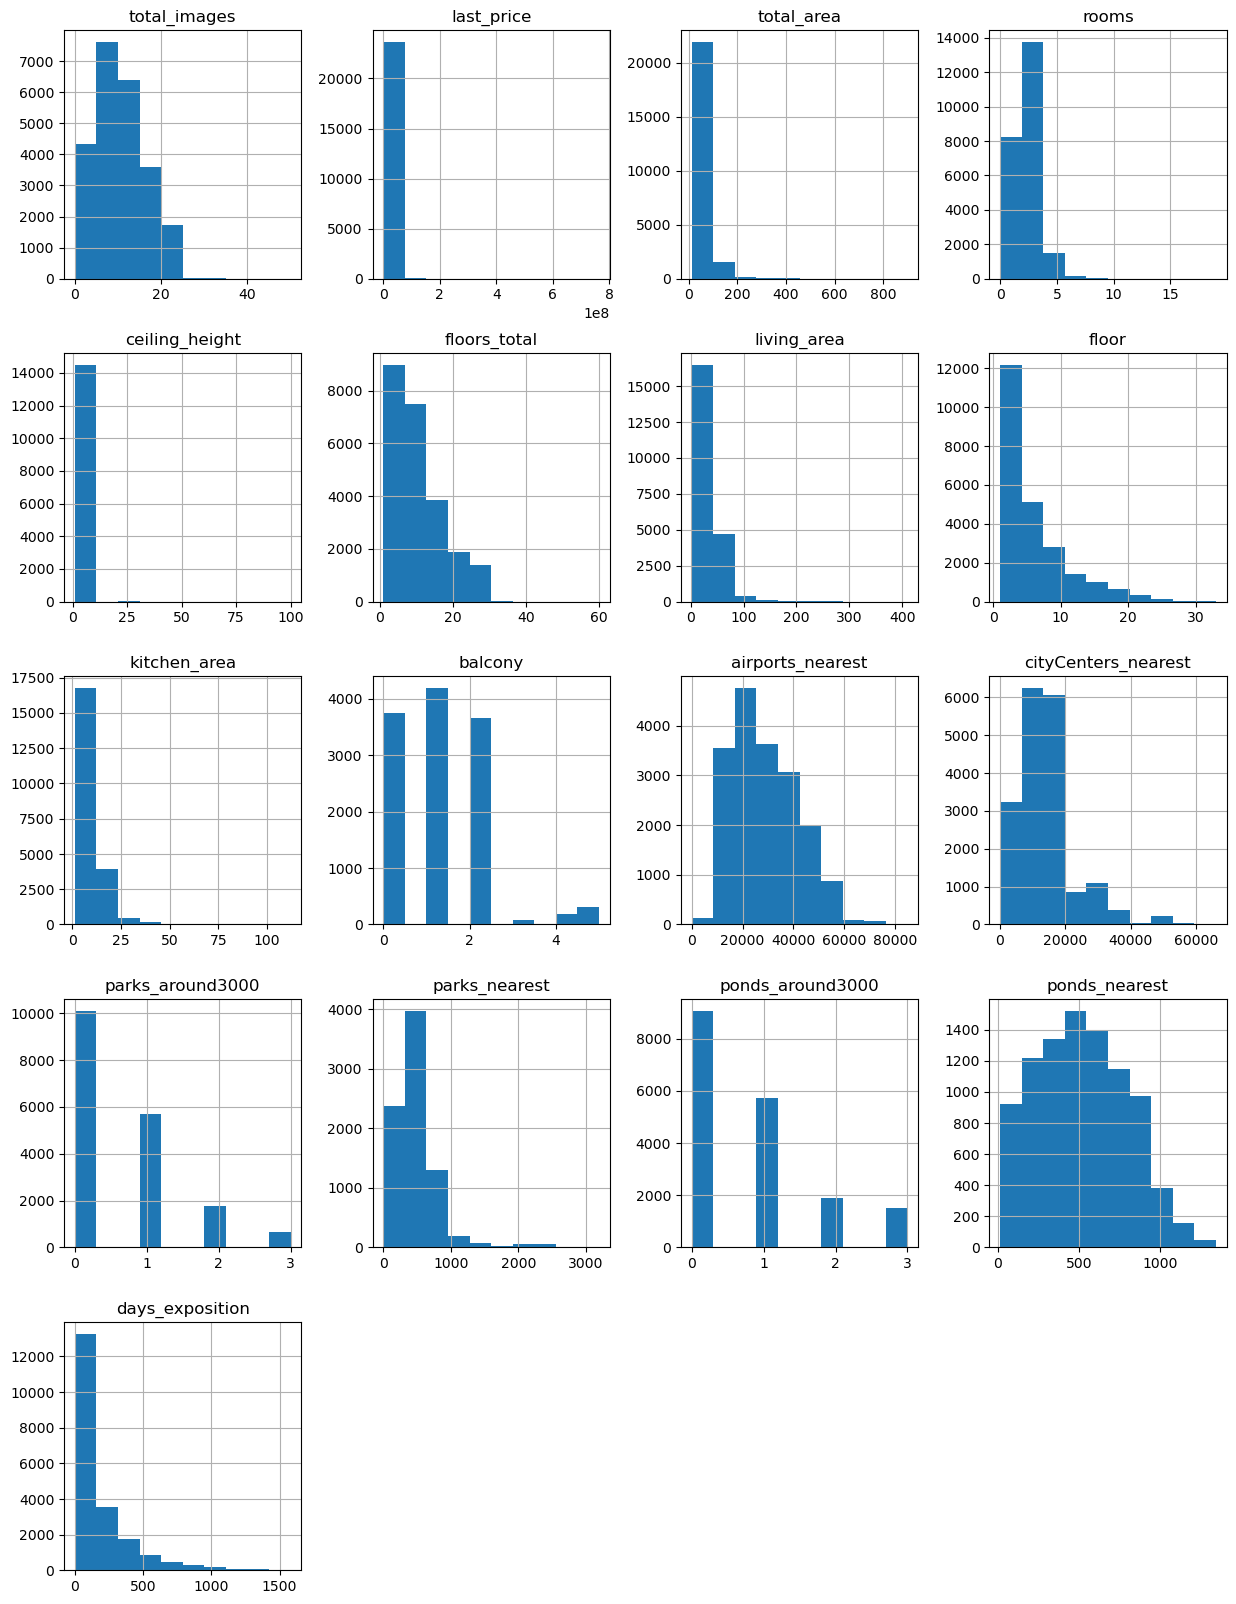

In [5]:
data.hist(figsize=(15, 20))
plt.show()

### Выполните предобработку данных

#### Анализ пропущенных значений

Количество пропусков в каждом столбце:

In [6]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [7]:
pip install missingno

  Obtaining dependency information for missingno from https://files.pythonhosted.org/packages/87/22/cd5cf999af21c2f97486622c551ac3d07361ced8125121e907f588ff5f24/missingno-0.5.2-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


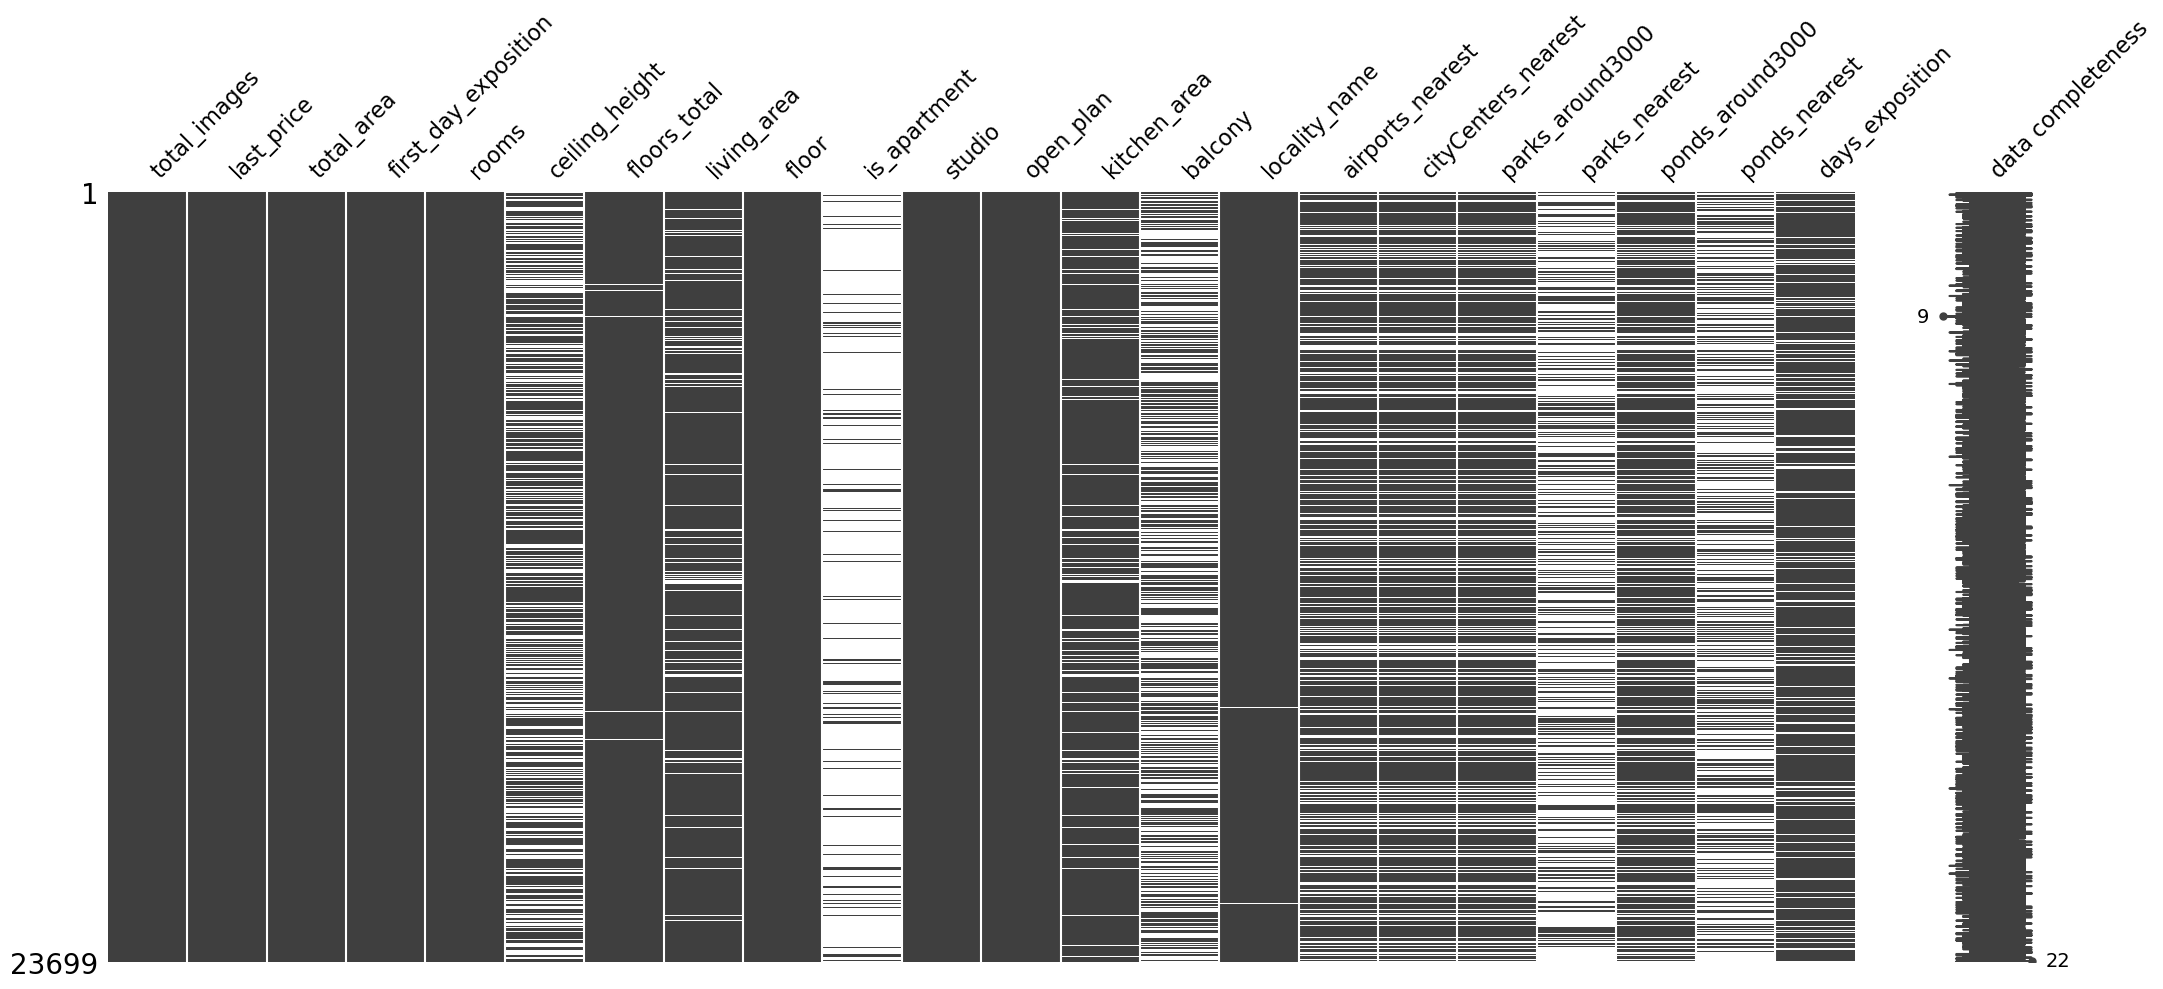

In [8]:
import missingno as msno

msno.matrix(data, labels=True)
plt.show()

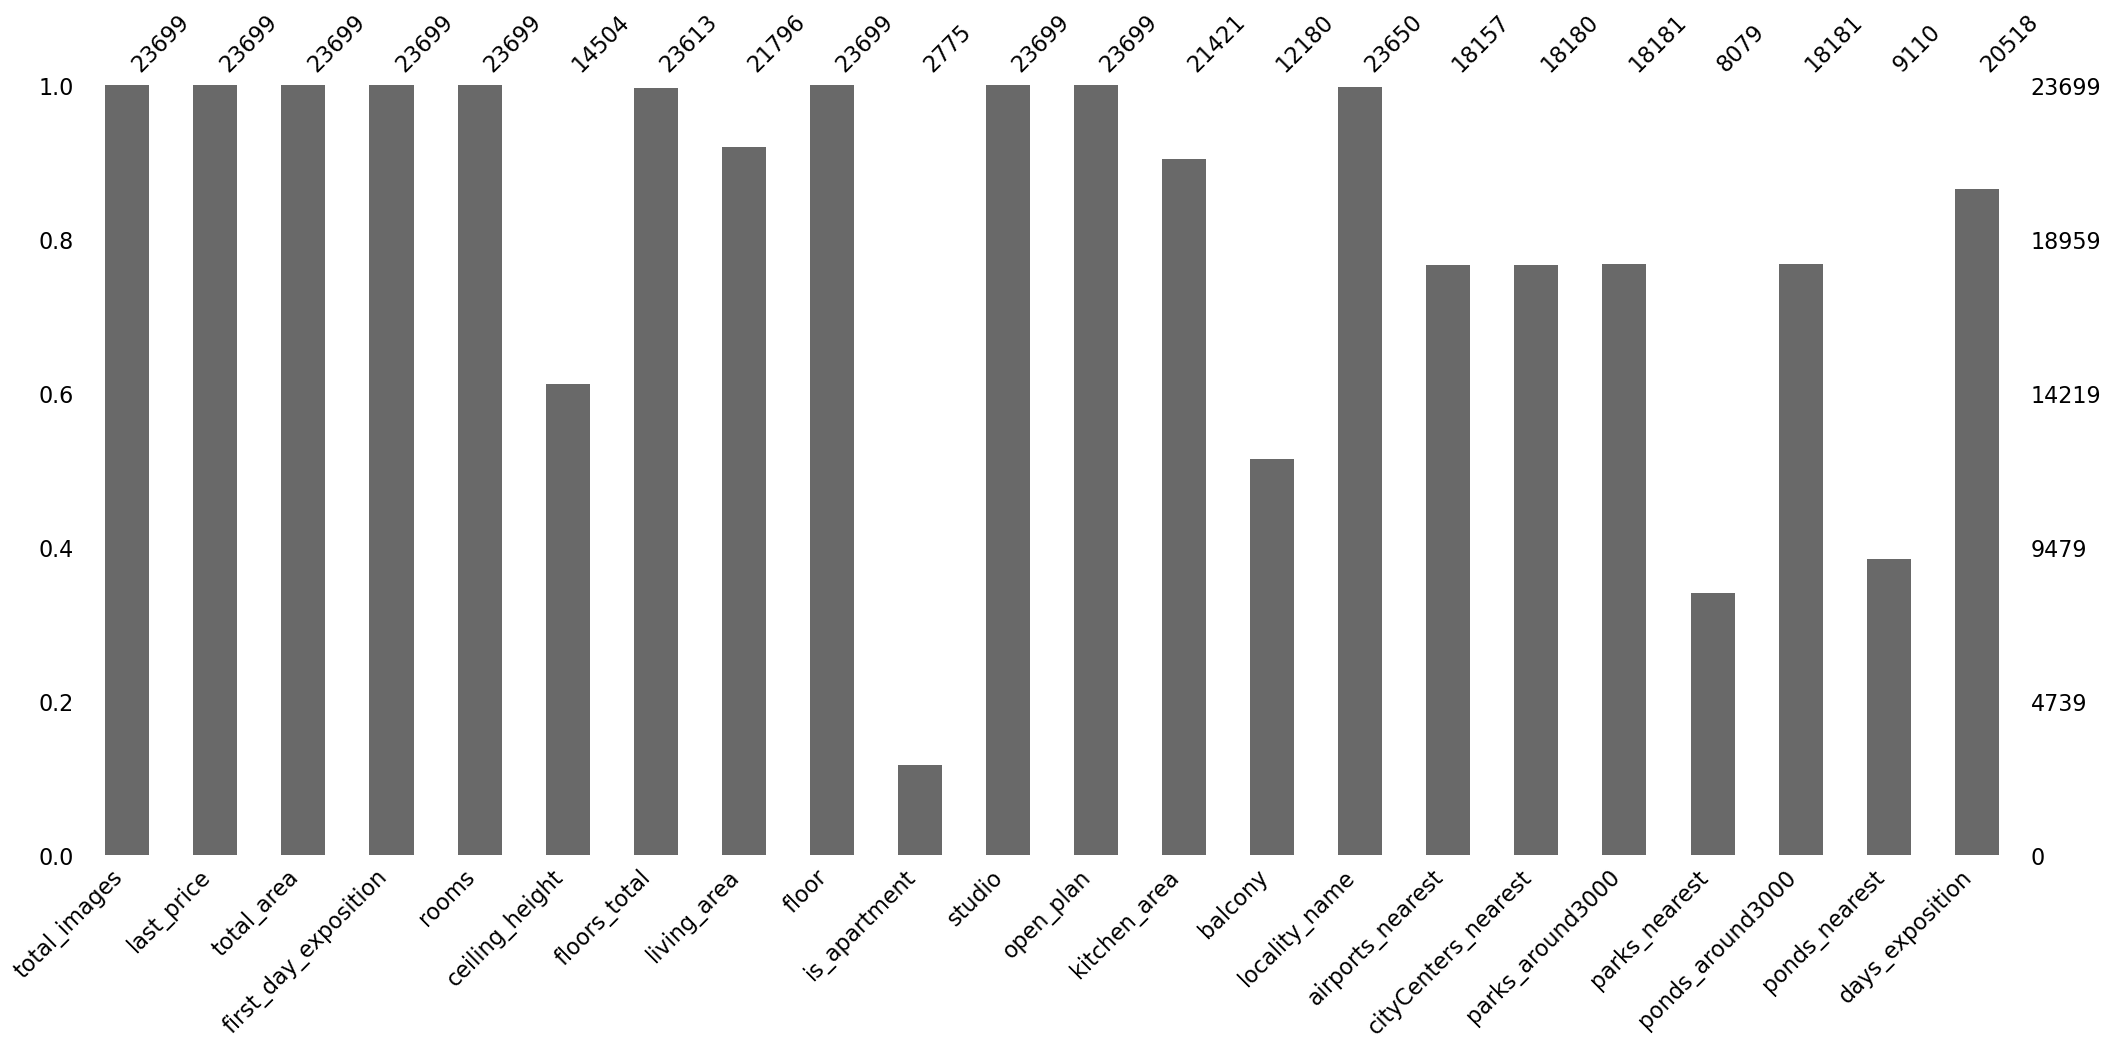

In [9]:
msno.bar(data)
plt.show()

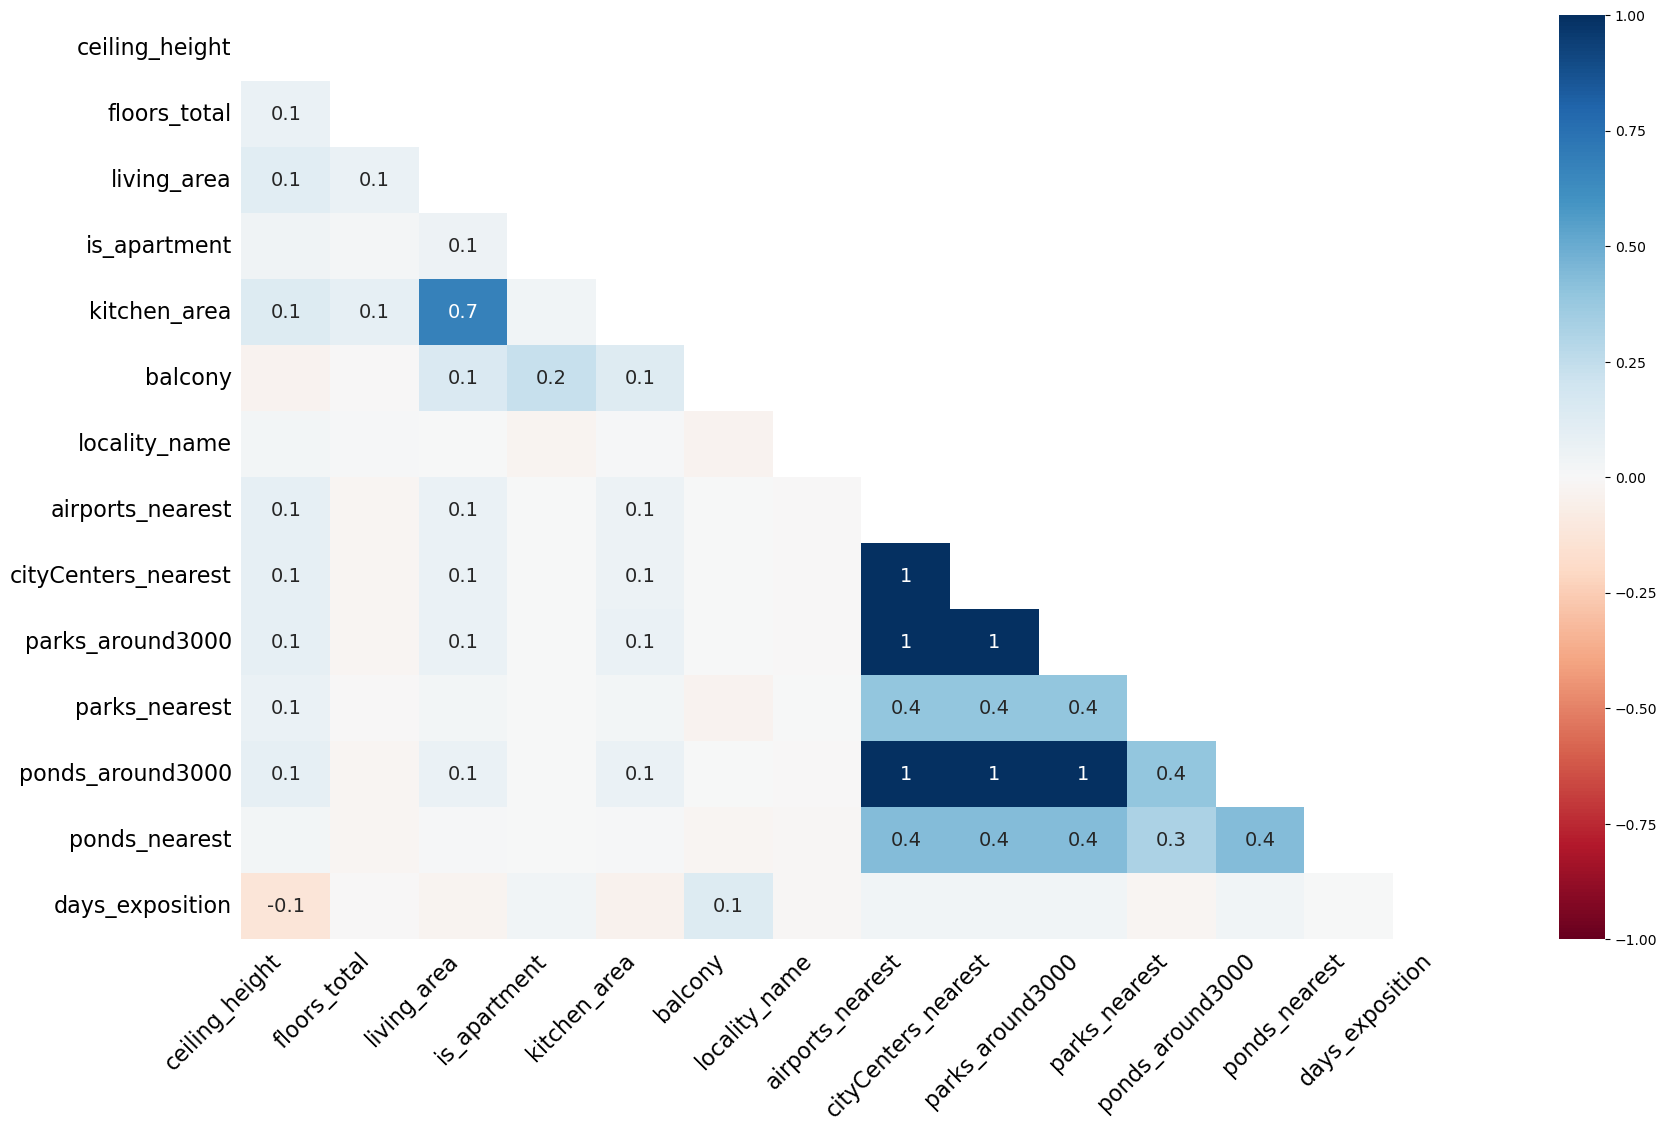

In [10]:
msno.heatmap(data)
plt.show()

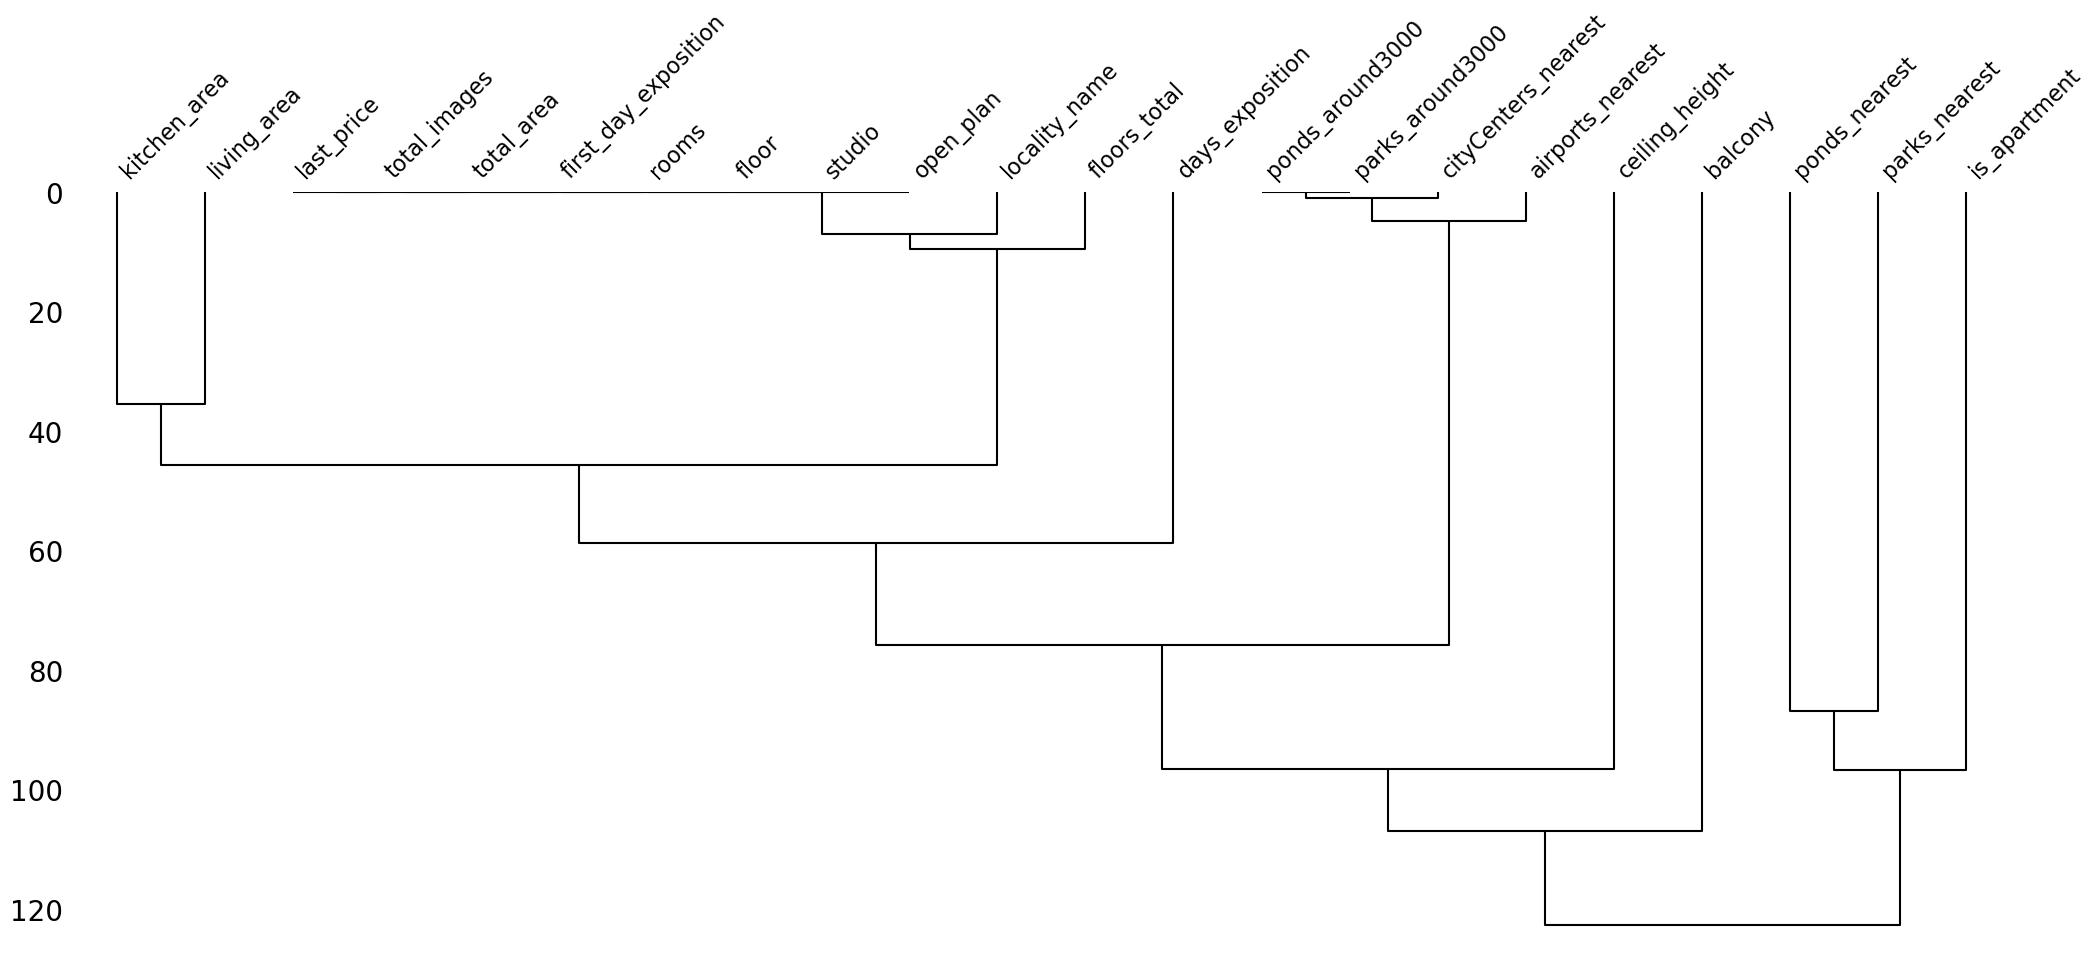

In [11]:
msno.dendrogram(data)
plt.show()

Из полученных данных следует, что пропуски присутствуют более чем в половине столбцов таблицы.
Исходя из смысла и названия каждого столбца, а также числа пропусков попытаемся определить какие из пропусков можно заменить.



- `ceiling_height` (высота потолков) содержит 9195 пропусков. Возможно, что пропущенные значения можно будет заменить средним значением, взятым по всему столбцу, предварительно проверив остальные значения в столбце на правдоподобность данных (сказанное насчет правдоподобности относится и ко всем остальным столбцам, имеющим пропуски).
- `floors_total` (общее число этажей в доме) содержит всего 86 пропусков. Возможно стоит заменить средним, не забыв округлить до целых. Возможно, что стоит оставить пропуски, так как этажность может сильно разнится от дома к дому. Также возможно заменить значениями из столбца `floor`. Этот вариант кажется наиболее оптимальным.
- `living_area` (жилая площадь) содержит 1903 пропуска. Можно заменить средним, предварительно посчитав средний процент жилой площади от общей для всех квартир где нет пропусков и затем применить этот процент к пропущенным значениям.
- `is_apartment` (апартаменты) - большинство пропуски. Смело заменяем на `False`, так как скорее всего отсутствие данных подразумевает что продается квартира, а не апартаменты.
- `kitchen_area` (площадь кухни) - 2278 пропусков. С пропусками можно поступить также, как и с пропусками в столбце `living_area`.
- `balcony` (балкон) - 11519 пропусков. Можно заменить на 0, так как отсутствующее значение вероятнее всего указывает на отсутствие балкона.
- `locality_name` (название населённого пункта) - 49 пропусков. Возможно стоит или заменить на "Санкт-Петербург", или заменить на "Не указано". Второй вариант выглядит более предпочтительным.
- `parks_around3000`, `ponds_around3000` - можно заменить пропущенные значения на 0, так как такие пропуски скорее всего говорят об отсутствии парка и водоема в радиусе 3000 м.
- `airports_nearest`, `cityCenters_nearest`, `parks_nearest`, `ponds_nearest` - вряд ли что-то получится сделать с этими пропусками, так как расстояния рассчитывались автоматически по геометкам. Надо будет проанализировать эти данные внимательно, так как некоторые значения числа пропусков повторяются. Возможно, получится установить какую-то взаимосвязь и причину пропусков.
- `days_exposition` (число дней от публикации до снятия) - тут пропуски могут говорить о том, что на момент формирования данных указанные квартиры до сих пор находились в продаже. Можно заменить на величину, посчитанную как разница между самой поздней датой в столбце `first_day_exposition` (считаем эту дату датой выгрузки датафрейма) и величиной, указанной столбце `first_day_exposition` для текущей строки. Но, скорее всего, лучше будет заменить пропуски на 0, так как в таком случае все подобные строки можно будет отфильтровать в случае необходимости.     

Заметил, что столбец cityCenters_nearest имеет некорректное название с точки зрения стилистики кода. Исправим это:

In [12]:
data = data.rename(columns = {'cityCenters_nearest': 'city_centers_nearest'})

#### Выявление аномальных значений

In [13]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.858475e+00,5.682529e+00,0.0,6.00,9.00,14.0,50.0
last_price,23699.0,6.541549e+06,1.088701e+07,12190.0,3400000.00,4650000.00,6800000.0,763000000.0
total_area,23699.0,6.034865e+01,3.565408e+01,12.0,40.00,52.00,69.9,900.0
rooms,23699.0,2.070636e+00,1.078405e+00,0.0,1.00,2.00,3.0,19.0
ceiling_height,14504.0,2.771499e+00,1.261056e+00,1.0,2.52,2.65,2.8,100.0
floors_total,23613.0,1.067382e+01,6.597173e+00,1.0,5.00,9.00,16.0,60.0
living_area,21796.0,3.445785e+01,2.203045e+01,2.0,18.60,30.00,42.3,409.7
floor,23699.0,5.892358e+00,4.885249e+00,1.0,2.00,4.00,8.0,33.0
kitchen_area,21421.0,1.056981e+01,5.905438e+00,1.3,7.00,9.10,12.0,112.0
balcony,12180.0,1.150082e+00,1.071300e+00,0.0,0.00,1.00,2.0,5.0


In [14]:
data.describe(include=['object', 'bool'])

,first_day_exposition,is_apartment,studio,open_plan,locality_name
count,23699,2775,23699,23699,23650
unique,1491,2,2,2,364
top,2018-02-01T00:00:00,False,False,False,Санкт-Петербург
freq,368,2725,23550,23632,15721


С помощью метода describe вывели общую информацию об исходных данных. Из полученной таблицы видно, что ни в одном столбце нет отрицательных величин. Это хороший знак.

Аномальными значениями выглядят следующие:
- число комнат 0 - с этим значением нужно будет что-то сделать. Как минимум заменить на 1.
- высота потолков 1 м - неправдоподное значение. Для всех величин, меньших заданной (например, 2.7 м), нужно поменять такие значения или на заданное минимальное, или на среднее, в котором не учитываются подобные выбросы.
- высота потолков 100 м - также неправдоподное значение. Нужно разобраться, как много таких больших значений и на что их можно заменить (уменьшить в 10 раз, или взять какое-то среднее, в котором не учитываются подобные выбросы).
- жилая площадь 2 м$^2$ - неправдоподное значение. Надо заменить на какое-то среднее через процент или установить факт того, что при внесении данных забыли 0 в конце.
- площадь кухни - 1.3 м$^2$ неправдоподное значение. Надо заменить на какое-то среднее через процент или установить факт того, что при внесении данных забыли 0 в конце.
- низкая стоимость - 12190 неправдоподно низкая стоимость для квартиры.

По другим данным сказать что-то о выбросах пока что нельзя.

#### Корректировка типов данных в столбцах таблицы и заполнение пропущенных значений

Выведем уникальные значения каждого столбца в цикле:

In [15]:
for col in data.columns:
    print(col)
    display(data[col].value_counts().sort_index())
    print()

total_images


total_images
0     1059
1      872
2      640
3      769
4      986
5     1301
6     1482
7     1521
8     1585
9     1725
10    1798
11    1362
12    1225
13    1015
14     986
15     948
16     761
17     650
18     642
19     603
20    1694
21      12
22       8
23      16
24       8
25       1
26       5
27       2
28       4
29       3
30       2
31       2
32       4
35       2
37       1
39       1
42       1
50       3
Name: count, dtype: int64


last_price


last_price
12190.0        1
430000.0       2
440000.0       1
450000.0       4
470000.0       3
              ..
300000000.0    1
330000000.0    1
401300000.0    1
420000000.0    1
763000000.0    1
Name: count, Length: 2978, dtype: int64


total_area


total_area
12.0     1
13.0     3
13.2     1
14.0     1
15.0     2
        ..
590.0    1
618.0    1
631.0    1
631.2    1
900.0    1
Name: count, Length: 2182, dtype: int64


first_day_exposition


first_day_exposition
2014-11-27T00:00:00    19
2014-11-29T00:00:00     1
2014-12-04T00:00:00     2
2014-12-05T00:00:00     1
2014-12-08T00:00:00     8
                       ..
2019-04-29T00:00:00    37
2019-04-30T00:00:00    27
2019-05-01T00:00:00    30
2019-05-02T00:00:00    11
2019-05-03T00:00:00    20
Name: count, Length: 1491, dtype: int64


rooms


rooms
0      197
1     8047
2     7940
3     5814
4     1180
5      326
6      105
7       59
8       12
9        8
10       3
11       2
12       1
14       2
15       1
16       1
19       1
Name: count, dtype: int64


ceiling_height


ceiling_height
1.00       1
1.20       1
1.75       1
2.00      11
2.20       1
          ..
26.00      1
27.00      8
27.50      1
32.00      2
100.00     1
Name: count, Length: 183, dtype: int64


floors_total


floors_total
1.0       25
2.0      383
3.0      668
4.0     1200
5.0     5788
6.0      914
7.0      592
8.0      390
9.0     3761
10.0    1174
11.0     203
12.0    1362
13.0     229
14.0     553
15.0     365
16.0    1376
17.0     833
18.0     505
19.0     339
20.0     271
21.0     158
22.0     286
23.0     352
24.0     469
25.0    1075
26.0     124
27.0     164
28.0      21
29.0       1
33.0       1
34.0       1
35.0      24
36.0       3
37.0       1
52.0       1
60.0       1
Name: count, dtype: int64


living_area


living_area
2.0      2
3.0      2
5.0      1
5.4      1
6.0      1
        ..
322.3    1
332.0    1
347.5    1
409.0    1
409.7    1
Name: count, Length: 1782, dtype: int64


floor


floor
1     2917
2     3368
3     3073
4     2804
5     2621
6     1305
7     1218
8     1083
9     1051
10     687
11     523
12     526
13     379
14     337
15     343
16     315
17     227
18     178
19     147
20     110
21     125
22     113
23     100
24      63
25      46
26      24
27      10
28       1
29       1
30       1
31       1
32       1
33       1
Name: count, dtype: int64


is_apartment


is_apartment
False    2725
True       50
Name: count, dtype: int64


studio


studio
False    23550
True       149
Name: count, dtype: int64


open_plan


open_plan
False    23632
True        67
Name: count, dtype: int64


kitchen_area


kitchen_area
1.30      1
2.00      7
2.30      1
2.40      1
2.89      1
         ..
93.20     1
100.00    1
100.70    1
107.00    1
112.00    1
Name: count, Length: 971, dtype: int64


balcony


balcony
0.0    3758
1.0    4195
2.0    3659
3.0      81
4.0     183
5.0     304
Name: count, dtype: int64


locality_name


locality_name
Бокситогорск             16
Волосово                 36
Волхов                  111
Всеволожск              398
Выборг                  237
                       ... 
село Путилово             2
село Рождествено          3
село Русско-Высоцкое      9
село Старая Ладога        2
село Шум                  1
Name: count, Length: 364, dtype: int64


airports_nearest


airports_nearest
0.0        1
6450.0     2
6914.0     1
6949.0     1
6989.0     6
          ..
83758.0    1
84006.0    1
84665.0    1
84853.0    1
84869.0    1
Name: count, Length: 8275, dtype: int64


city_centers_nearest


city_centers_nearest
181.0      1
208.0      1
215.0      1
287.0      1
291.0      1
          ..
64857.0    1
65105.0    1
65764.0    1
65952.0    1
65968.0    1
Name: count, Length: 7642, dtype: int64


parks_around3000


parks_around3000
0.0    10106
1.0     5681
2.0     1747
3.0      647
Name: count, dtype: int64


parks_nearest


parks_nearest
1.0       1
3.0       1
4.0       1
7.0       1
9.0       2
         ..
2905.0    1
2984.0    1
3013.0    1
3064.0    1
3190.0    2
Name: count, Length: 995, dtype: int64


ponds_around3000


ponds_around3000
0.0    9071
1.0    5717
2.0    1892
3.0    1501
Name: count, dtype: int64


ponds_nearest


ponds_nearest
13.0      2
16.0      8
19.0      4
20.0      5
22.0      7
         ..
1299.0    1
1313.0    1
1337.0    1
1341.0    2
1344.0    1
Name: count, Length: 1096, dtype: int64


days_exposition


days_exposition
1.0         1
2.0         3
3.0       158
4.0       176
5.0       152
         ... 
1512.0      2
1513.0      1
1553.0      1
1572.0      1
1580.0      1
Name: count, Length: 1141, dtype: int64

Выведем тип каждого столбца:

In [16]:
for col in data.columns:
    print(f'{col} - {type(data[col][0])}')          

total_images - <class 'numpy.int64'>
last_price - <class 'numpy.float64'>
total_area - <class 'numpy.float64'>
first_day_exposition - <class 'str'>
rooms - <class 'numpy.int64'>
ceiling_height - <class 'numpy.float64'>
floors_total - <class 'numpy.float64'>
living_area - <class 'numpy.float64'>
floor - <class 'numpy.int64'>
is_apartment - <class 'float'>
studio - <class 'numpy.bool_'>
open_plan - <class 'numpy.bool_'>
kitchen_area - <class 'numpy.float64'>
balcony - <class 'numpy.float64'>
locality_name - <class 'str'>
airports_nearest - <class 'numpy.float64'>
city_centers_nearest - <class 'numpy.float64'>
parks_around3000 - <class 'numpy.float64'>
parks_nearest - <class 'numpy.float64'>
ponds_around3000 - <class 'numpy.float64'>
ponds_nearest - <class 'numpy.float64'>
days_exposition - <class 'numpy.float64'>


Анализ уникальных значений каждого столбца и типа данных показал, что необходимо изменить тип данных у следующих столбцов:
- `first_day_exposition` с `str` на `datetime64`, так как это тип данных, хранящих время. В таком виде этот столбец понадобится для дальнейших расчетов.
- `floors_total` с `float64` на `int`, так как общее число этажей не может быть дробным. При изменении типа дробную часть нужно будет отбросить, при этом проверить, что этаж, на котором продается квартира, не окажется больше получившегося общего числа этажей в доме.
- `is_apartment` с `float` на `bool`, так как подразумевается категориальный тип переменной с возможными вариантами да/нет.
- `parks_around3000` с `float` на `int`, так как число парков не может быть дробным. Округлять не нужно, так как все уникальные значения не имеют дробной части.
- `ponds_around3000` с `float` на `int`, так как число водоемов не может быть дробным. Округлять не нужно, так как все уникальные значения не имеют дробной части.
- `days_exposition` с `float` на `int`, так как число дней можно считать целым, отбросив дробную часть (на результаты это не должно повлиять).


##### Корректировка типа даты `first_day_exposition`

In [17]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')


In [18]:
data['first_day_exposition'].head()

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]

После корректировки типа данных необходимо проверить отсутствие аномальных значений в столбце `first_day_exposition` (смотрим на минимальную и максимальную даты):

In [20]:
data['first_day_exposition'].describe(datetime_is_numeric=True)

TypeError: NDFrame.describe() got an unexpected keyword argument 'datetime_is_numeric'

Проверка показала, что аномальные значения отсутствуют.

##### Корректировка типа общего числа этажей `floors_total`

In [22]:
data['floors_total'] = data['floors_total'].astype('Int32')

In [23]:
data['floors_total'].sample(5)

12359    15
1094      8
22696     7
12070    16
14692     3
Name: floors_total, dtype: Int32

Проверим, что в ходе изменения типа не получилось такого, что общее число этажей меньше этажа, на котором продавалась квартира:

In [24]:
import numpy as np
for i in data.index:
    try:
        if data['floors_total'][i] - data['floor'][i] < 0:
            print(f'Строка {i} - требуется коректировка общего числа этажей!')      
    except:
        continue

Выполнение цикла возвращает пустой результат - следовательно, ошибочные строки в таблице отсутствуют.

##### Заполнение пропусков в столбце `floors_total`

В тех строках, где значение `floors_total` отсутствует, предлагается заменить их на значение из столбца `floor`. Данная корректировка справедлива, так как число пропусков совсем невелико (86) по сравнению с общим числом записей (23699). Такой подход не должен сильно сказаться на средних показателях. Также мы исключаем ситуацию, в которой значение из поля `floor` окажется больше нового значения в поле `floors_total`.

In [25]:
data['floors_total'] = data['floors_total'].fillna(data['floor'])
print(f'Число пропусков в столбце "floors_total" после выполнения замены: {data["floors_total"].isna().sum()}')

Число пропусков в столбце "floors_total" после выполнения замены: 0


##### Заполнение пропусков в `is_apartment` и изменение типа данных:

Как было написано выше, в данном столбце все пропуски можно заменить на 0, что будет подразумевать под собой продажу квартиры, а не апартаментов.

In [26]:
data['is_apartment'] = data['is_apartment'].fillna(0)
print(f'Число пропусков в столбце "is_apartment" после выполнения замены: {data["is_apartment"].isna().sum()}')

Число пропусков в столбце "is_apartment" после выполнения замены: 0


Изменение типа с `float` на `bool`:

In [27]:
data['is_apartment'] = data['is_apartment'].astype('bool')
data['is_apartment'].sample(5)

20707    False
1012     False
19666    False
13391    False
9972     False
Name: is_apartment, dtype: bool

##### Корректировка типа столбца `parks_around3000`

In [28]:
data['parks_around3000'] = data['parks_around3000'].astype('Int32')
data['parks_around3000'].sample(5)

23444    0
12637    0
21936    1
7235     0
8731     0
Name: parks_around3000, dtype: Int32

##### Корректировка типа столбца `ponds_around3000`

In [29]:
data['ponds_around3000'] = data['ponds_around3000'].astype('Int32')
data['ponds_around3000'].sample(5)

17719    <NA>
18724    <NA>
22582       0
17911       3
5477        0
Name: ponds_around3000, dtype: Int32

##### Замена пустых значений в столбцах `parks_around3000`, `ponds_around3000`, `airports_nearest`, `city_centers_nearest`, `parks_nearest`, `ponds_nearest`

В начале работы было замечено, что число пропусков в `parks_around3000` и `ponds_around3000` одинаковое. Можно попробовать установить какую-то взаимосвязь между ними.

Запишем в новые переменные индексы только тех строк таблицы, где есть пропуски в `parks_around3000` и в `ponds_around3000`, а затем сравним их:

In [30]:
parks_around3000_null = data[data['parks_around3000'].isnull()].index
ponds_around3000_null = data[data['ponds_around3000'].isnull()].index
print(f'Число пропусков в  "parks_around3000": {len(parks_around3000_null)}')
print(f'Число пропусков в  "ponds_around3000": {len(ponds_around3000_null)}')

Число пропусков в  "parks_around3000": 5518
Число пропусков в  "ponds_around3000": 5518


Сравним полученные переменные между собой через множества:

In [31]:
set(ponds_around3000_null) - set(ponds_around3000_null)

set()

Получили пустое множество. Следовательно, пропуски в столбцах `parks_around3000` и `ponds_around3000` находятся в одних и тех же строках. Выведем первые 20 строк с пропусками таблицы `data`:

In [32]:
data[data['ponds_around3000'].isnull()].head(20)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5,10,2890000.0,30.40,2018-09-10,1,NaN,12,14.40,5,False,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,<NA>,NaN,<NA>,NaN,55.0
8,20,2900000.0,33.16,2018-05-23,1,NaN,27,15.43,26,False,...,8.81,NaN,посёлок Мурино,NaN,NaN,<NA>,NaN,<NA>,NaN,189.0
12,10,3890000.0,54.00,2016-06-30,2,NaN,5,30.00,5,False,...,9.00,0.0,Сертолово,NaN,NaN,<NA>,NaN,<NA>,NaN,90.0
22,20,5000000.0,58.00,2017-04-24,2,2.75,25,30.00,15,False,...,11.00,2.0,деревня Кудрово,NaN,NaN,<NA>,NaN,<NA>,NaN,60.0
30,12,2200000.0,32.80,2018-02-19,1,NaN,9,NaN,2,False,...,NaN,NaN,Коммунар,NaN,NaN,<NA>,NaN,<NA>,NaN,63.0
37,10,1990000.0,45.80,2017-10-28,2,2.50,5,NaN,1,False,...,NaN,NaN,поселок городского типа Красный Бор,NaN,NaN,<NA>,NaN,<NA>,NaN,196.0
38,10,3150000.0,40.00,2018-03-29,1,2.75,18,16.30,9,False,...,11.60,NaN,посёлок Мурино,NaN,NaN,<NA>,NaN,<NA>,NaN,103.0
47,17,3600000.0,56.10,2018-10-18,3,NaN,4,42.50,3,False,...,5.70,1.0,Гатчина,NaN,NaN,<NA>,NaN,<NA>,NaN,179.0
60,3,2740000.0,35.00,2018-01-01,1,NaN,12,NaN,8,False,...,NaN,NaN,посёлок Мурино,NaN,NaN,<NA>,NaN,<NA>,NaN,11.0
62,0,4800000.0,78.60,2017-09-17,3,2.80,9,48.80,5,False,...,11.90,2.0,Сертолово,NaN,NaN,<NA>,NaN,<NA>,NaN,5.0


Из выведенной таблицы видно, что у 20 строк с пропусками в `parks_around3000` и `ponds_around3000` также есть пропуски в столбцах `airports_nearest`, `city_centers_nearest`, `parks_nearest`, `ponds_nearest` - это данные, полученные автоматически. 

Проверим, что эта корреляция сохраняется для всех 5518 строк:

In [33]:
len(data[(data['parks_around3000'].isnull()) &
     (data['airports_nearest'].isnull()) &
     (data['city_centers_nearest'].isnull()) &
     (data['parks_nearest'].isnull()) &    
     (data['ponds_nearest'].isnull())    
    ].index)

5518

Таким образом установлено, что у 5518 строк отсутствуют все данные, собираемые геосервисом. Для таких строк можно заполнить пропуски строкой "Нет данных". Прежде, чем сделать это, проверим оставшиеся пропуски в столбцах `airports_nearest`, `city_centers_nearest`, `parks_nearest`, `ponds_nearest`.

Выведем те строки, где отсутствуют пропуски в `parks_around3000`, но есть пропуски в `parks_nearest`:

In [34]:
data.query('parks_around3000.index not in @parks_around3000_null and parks_nearest != parks_nearest').shape[0]

10102

In [35]:
data.query('parks_around3000.index not in @parks_around3000_null and parks_nearest != parks_nearest').head(20)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,False,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0
6,6,3700000.0,37.3,2017-11-02,1,NaN,26,10.6,6,False,...,14.4,1.0,посёлок Парголово,52996.0,19143.0,0,NaN,0,NaN,155.0
7,5,7915000.0,71.6,2019-04-18,2,NaN,24,NaN,22,False,...,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0,NaN,0,NaN,NaN
9,18,5400000.0,61.0,2017-02-26,3,2.50,9,43.6,7,False,...,6.5,2.0,Санкт-Петербург,50898.0,15008.0,0,NaN,0,NaN,289.0
11,9,3300000.0,44.0,2018-08-27,2,NaN,5,31.0,4,False,...,6.0,1.0,Ломоносов,48252.0,51677.0,0,NaN,0,NaN,7.0
14,1,4400000.0,36.0,2016-06-23,1,NaN,6,17.0,1,False,...,8.0,0.0,Пушкин,20782.0,30759.0,0,NaN,1,96.0,203.0
17,6,4180000.0,36.0,2016-09-09,1,NaN,17,16.5,7,False,...,11.0,1.0,Санкт-Петербург,33564.0,14616.0,0,NaN,1,859.0,571.0
19,16,14200000.0,121.0,2019-01-09,3,2.75,16,76.0,8,False,...,12.0,NaN,Санкт-Петербург,38900.0,12843.0,0,NaN,0,NaN,97.0
20,12,6120000.0,80.0,2017-09-28,3,2.70,27,48.0,11,False,...,12.0,2.0,посёлок Парголово,53134.0,19311.0,0,NaN,0,NaN,74.0
25,3,6800000.0,76.0,2015-10-01,2,2.75,23,39.0,18,False,...,15.0,2.0,Санкт-Петербург,34967.0,14640.0,0,NaN,1,564.0,300.0


Какой-то явной зависимости не видно. Проделаем аналогичную операцию для столбцов `airports_nearest`, `city_centers_nearest`, `ponds_nearest`:

In [36]:
data.query('parks_around3000.index not in @parks_around3000_null and ponds_nearest != ponds_nearest').shape[0]

9071

In [37]:
data.query('parks_around3000.index not in @parks_around3000_null and ponds_nearest != ponds_nearest').head(20)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,False,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0
6,6,3700000.0,37.3,2017-11-02,1,NaN,26,10.6,6,False,...,14.4,1.0,посёлок Парголово,52996.0,19143.0,0,NaN,0,NaN,155.0
7,5,7915000.0,71.6,2019-04-18,2,NaN,24,NaN,22,False,...,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0,NaN,0,NaN,NaN
9,18,5400000.0,61.0,2017-02-26,3,2.50,9,43.6,7,False,...,6.5,2.0,Санкт-Петербург,50898.0,15008.0,0,NaN,0,NaN,289.0
11,9,3300000.0,44.0,2018-08-27,2,NaN,5,31.0,4,False,...,6.0,1.0,Ломоносов,48252.0,51677.0,0,NaN,0,NaN,7.0
16,11,6700000.0,82.0,2017-11-23,3,3.05,5,55.6,1,False,...,9.0,NaN,Санкт-Петербург,22108.0,10698.0,3,420.0,0,NaN,397.0
18,8,3250000.0,31.0,2017-01-27,1,2.50,5,19.4,2,False,...,5.6,1.0,Санкт-Петербург,44060.0,10842.0,1,759.0,0,NaN,168.0
19,16,14200000.0,121.0,2019-01-09,3,2.75,16,76.0,8,False,...,12.0,NaN,Санкт-Петербург,38900.0,12843.0,0,NaN,0,NaN,97.0
20,12,6120000.0,80.0,2017-09-28,3,2.70,27,48.0,11,False,...,12.0,2.0,посёлок Парголово,53134.0,19311.0,0,NaN,0,NaN,74.0
21,13,3200000.0,31.6,2018-03-14,1,NaN,5,16.9,2,False,...,5.7,1.0,Санкт-Петербург,36064.0,9722.0,1,248.0,0,NaN,310.0


Тут также не прослеживается какой-либо зависимости.

In [38]:
data.query('parks_around3000.index not in @parks_around3000_null and airports_nearest != airports_nearest').shape[0]

24

In [39]:
data.query('parks_around3000.index not in @parks_around3000_null and airports_nearest != airports_nearest')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
733,18,18700000.0,109.7,2018-02-03,3,2.75,21,57.2,13,False,...,15.3,1.0,Санкт-Петербург,NaN,13355.0,1,735.0,0,NaN,112.0
974,8,25897000.0,149.0,2018-03-26,4,2.74,7,NaN,6,False,...,NaN,NaN,Санкт-Петербург,NaN,9734.0,2,469.0,3,263.0,90.0
2415,17,9500000.0,67.4,2017-04-15,2,2.80,23,37.6,4,False,...,12.0,0.0,Санкт-Петербург,NaN,13355.0,1,735.0,0,NaN,56.0
7521,16,43500000.0,245.8,2015-12-17,3,4.45,7,170.8,7,True,...,25.0,1.0,Санкт-Петербург,NaN,5735.0,2,110.0,0,NaN,1067.0
7542,10,6900000.0,50.0,2016-03-17,1,2.80,23,20.0,12,False,...,10.0,0.0,Санкт-Петербург,NaN,13355.0,1,735.0,0,NaN,317.0
8018,20,84000000.0,507.0,2015-12-17,5,4.45,7,301.5,7,True,...,45.5,1.0,Санкт-Петербург,NaN,5735.0,2,110.0,0,NaN,1078.0
8628,0,8000000.0,48.9,2018-02-23,1,NaN,6,NaN,4,False,...,NaN,NaN,Санкт-Петербург,NaN,5735.0,2,110.0,0,NaN,60.0
9054,5,13000000.0,71.8,2017-09-12,2,2.75,10,32.5,5,False,...,18.9,2.0,Санкт-Петербург,NaN,9734.0,2,469.0,3,263.0,156.0
9880,11,5300000.0,51.0,2018-01-10,2,NaN,5,22.6,4,False,...,15.8,NaN,Санкт-Петербург,NaN,4892.0,0,NaN,2,369.0,13.0
10669,9,3400000.0,46.0,2018-09-01,2,2.60,5,28.0,5,False,...,6.7,NaN,Санкт-Петербург,NaN,21377.0,0,NaN,0,NaN,106.0


Всего лишь 24 строки без учета отброшенных 5518.

In [40]:
data.query('parks_around3000.index not in @parks_around3000_null and city_centers_nearest != city_centers_nearest').head(20)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
20190,2,10500000.0,85.0,2019-01-08,3,3.0,3,55.5,2,False,...,8.0,1.0,Пушкин,15527.0,NaN,1,134.0,0,NaN,NaN


1 строка без учета отброшенных 5518.

**Вывод по пропускам в столбцах `parks_around3000`, `ponds_around3000`, `airports_nearest`, `city_centers_nearest`, `parks_nearest`, `ponds_nearest`**

У 5518 строк отсутствуют данные по всем вышеназванным столбцам. У столбцов `parks_nearest`, `ponds_nearest` помимо отмеченных общих 5518 пропусков присутствует также большое число отдельных пропусков - общее число пропусков составляет порядка 9000 - 10000 в каждом. У остальных столбцов `airports_nearest`, `city_centers_nearest` число отдельных пропусков совсем небольшое.

Установить какую-либо взаимосвязь между найденными пропусками и остальными данными не удалось. Так как в указанных столбцах хранятся числовые данные, то добавление строки "Нет данных" вместо пропусков недопустимо. Также недопустимо пропущенные значения заменить на 0. По этой причине, создадим в датафрейме новый столбец `geo_data`, в который добавим следующие значения:
- "Empty" - во всех вышеназванных столбцах отсутствуют значения
- "Not_enough" - в некоторых вышеназванных столбцах отсутствуют значения
- "Filled" - во всех вышеназванных столбцах записаны данные

Для этой цели напишем функцию, которая будет получать строку датафрейма и на основе анализа вышеназванных столбцов выдавать требуемое значение.

In [41]:
def geo_data(data):
    '''Функция принимает на вход строку датафрейма и записывает результат "Empty",
    "Not_enough", "Filled" в зависимости от выполнения условий'''
    try:
        if (pd.isnull(data['parks_around3000']) and pd.isnull(data['airports_nearest']) and
         pd.isnull(data['city_centers_nearest']) and pd.isnull(data['parks_nearest']) and    
         pd.isnull(data['ponds_nearest'])):
            val = 'Empty'
        elif (pd.isnull(data['parks_around3000']) or pd.isnull(data['airports_nearest']) or
         pd.isnull(data['city_centers_nearest']) or pd.isnull(data['parks_nearest']) or    
         pd.isnull(data['ponds_nearest'])):
            val = 'Not_enough'
        else:
            val = 'Filled'
        return val
    except:
        return print('Ошибка!')

Создаем новый столбец и заполняем его:

In [42]:
data['geo_data'] = data.apply(geo_data, axis=1)

Проверяем уникальные значения нового столбца:

In [43]:
data['geo_data'].value_counts()

geo_data
Not_enough    13364
Empty          5518
Filled         4817
Name: count, dtype: int64

In [44]:
data[(data['parks_around3000'].isnull()) &
     (data['airports_nearest'].isnull()) &
     (data['city_centers_nearest'].isnull()) &
     (data['parks_nearest'].isnull()) &    
     (data['ponds_nearest'].isnull())]['geo_data'].value_counts()

geo_data
Empty    5518
Name: count, dtype: int64

In [45]:
data[(data['parks_around3000'].isnull()) |
     (data['airports_nearest'].isnull()) |
     (data['city_centers_nearest'].isnull()) |
     (data['parks_nearest'].isnull()) |    
     (data['ponds_nearest'].isnull())]['geo_data'].value_counts()

geo_data
Not_enough    13364
Empty          5518
Name: count, dtype: int64

In [46]:
data[~((data['parks_around3000'].isnull()) |
     (data['airports_nearest'].isnull()) |
     (data['city_centers_nearest'].isnull()) |
     (data['parks_nearest'].isnull()) |    
     (data['ponds_nearest'].isnull()))]['geo_data'].value_counts()

geo_data
Filled    4817
Name: count, dtype: int64

Проверка показала корректное занесение признака в новый столбец.

##### Корректировка типа и заполнение пропусков в столбце `days_exposition`

Анализ данного столбца показал, что требуется заменить тип с `float` на `int`, а также заполнить пропущенные значения. Пропуски было решено заменить на 0, так как в исходных данных значения 0 в этом столбце нет. В дальнейшем будем помнить, что 0 значение соответствует пропуску и обозначает, что квартира так и не была продана к моменту создания датафрейма.

In [47]:
data['days_exposition'].dtypes

dtype('float64')

In [48]:
data['days_exposition'] = data['days_exposition'].fillna(0)
data['days_exposition'] = pd.to_numeric(data['days_exposition'], downcast='integer')

In [49]:
data['days_exposition'].isna().sum()

0

In [50]:
data['days_exposition'].dtypes

dtype('int16')

##### Заполнение пропусков и обработка аномальных значений в `ceiling_height`

Было решено написать функцию, которая бы рассчитывала среднее и медианное, так как эти величины потребуется расчитывать далее неоднократно для различных столбцов.

In [51]:
def mean_med(data, column=None):
    '''Функция принимает на вход датафрейм или Series и название столбца (только для датафрейма, формат str),
    по которому надо посчитать среднее и медиану. Выдает эти значения во внешние переменные и печать'''
    try:
        if column==None:
            mean = np.round(data.mean(), 4)
            med = np.round(data.median(), 4)
        else:   
            mean = np.round(data[column].mean(), 4)
            med = np.round(data[column].median(), 4)
        print(f'Среднее арифметическое: {mean}\nМедиана: {med}')
        return mean, med
    except:
        print('Ошибка!')

Общее количество пропусков в столбце `ceiling_height`:

In [52]:
data['ceiling_height'].isna().sum()

9195

Уникальные значения, меньшие 2.5 м (принимаем, что все что ниже - аномальные значения):

In [53]:
ceiling_height_anomaly_low = data[data['ceiling_height'] < 2.5]['ceiling_height'].sort_values()
ceiling_height_anomaly_low

22590    1.00
5712     1.20
16934    1.75
22960    2.00
552      2.00
         ... 
10100    2.48
5735     2.48
3703     2.48
1677     2.48
21521    2.49
Name: ceiling_height, Length: 73, dtype: float64

Уникальные значения, большие 6 м (принимаем, что все что выше - аномальные значения):

In [54]:
ceiling_height_anomaly_high = data[data['ceiling_height'] > 6]['ceiling_height'].sort_values()
ceiling_height_anomaly_high

3474       8.0
17442      8.0
15743      8.0
5863       8.3
22309     10.3
15061     14.0
17496     20.0
20507     22.6
5076      24.0
355       25.0
18545     25.0
11285     25.0
14382     25.0
9379      25.0
6246      25.0
4643      25.0
5669      26.0
5807      27.0
5246      27.0
17857     27.0
4876      27.0
20478     27.0
21824     27.0
10773     27.0
22938     27.0
21377     27.5
3148      32.0
22336     32.0
22869    100.0
Name: ceiling_height, dtype: float64

In [55]:
print(f'Общее число аномальных значений: {len(ceiling_height_anomaly_high)+len(ceiling_height_anomaly_low)}')

Общее число аномальных значений: 102


In [56]:
print(f'Процент числа аномальных значений от всех значений: {np.round((len(ceiling_height_anomaly_high)+len(ceiling_height_anomaly_low)) / data.shape[0] *100, 2)} %')

Процент числа аномальных значений от всех значений: 0.43 %


Таким образом, общее число аномальных значений в стобце `ceiling_height` невелико.

Посмотрим, каким будет среднее и медиана при исключении аномалий:

In [57]:
ceiling_height_mean_filter, ceiling_height_median_filter = (
    mean_med(data[(data['ceiling_height'] > 2.5) & (data['ceiling_height'] < 6)], 'ceiling_height'))

Среднее арифметическое: 2.8021
Медиана: 2.7


Получили ожидаемый результат - среднее оказалось близким к медианному. Обе величины - правдоподобные.

Проверим, как на них сказываются аномальные значения:

In [58]:
ceiling_height_mean_full, ceiling_height_median_full = mean_med(data, 'ceiling_height')

Среднее арифметическое: 2.7715
Медиана: 2.65


Обе величины немного уменьшились, так как среди аномалий преобладают величины меньше 2.5. По результатам проведенных расчетов предлагается для заполнений пропусков использовать значение медианы, посчитанное без аномалий, так как ее значение (2.7 м) совпадает с типичной высотой потолка в квартирах.

In [59]:
data['ceiling_height'] = data['ceiling_height'].fillna(ceiling_height_median_filter)

Проверям отсутствие пропусков после заполнения:

In [60]:
data['ceiling_height'].isna().sum()

0

Аномальные значения также предлагается заменить на медианное, так как число аномалий совсем невелико по сравнению с общим числом строк таблицы:

In [61]:
data.loc[(data['ceiling_height'] < 2.5) | (data['ceiling_height'] > 6), 'ceiling_height'] = ceiling_height_median_filter

##### Заполнение пропусков и обработка аномальных значений в `living_area`

Общее количество пропусков в столбце `living_area`:

In [62]:
data['living_area'].isna().sum()

1903

Так как с параметром `living_area` напрямую связан параметр `total_area`, то логично сперва проверить наличие аномальных значений в столбце `total_area`. 

Выведем те квартиры, у которых общая площадь составляет менее 20 м$^2$:

In [63]:
total_area_anomaly = data[data['total_area'] < 20]['total_area'].sort_values()
total_area_anomaly

19904    12.00
19807    13.00
19546    13.00
17961    13.00
19558    13.20
19642    14.00
12040    15.00
16949    15.00
8886     15.50
9412     16.00
10208    17.00
716      17.00
22356    17.20
9157     17.60
21802    17.78
20714    18.00
6084     18.00
12996    18.00
19311    18.00
4542     18.00
8729     18.40
12881    18.50
8755     18.80
23191    18.90
8454     19.00
9817     19.00
5855     19.50
Name: total_area, dtype: float64

Выведем также стоимость этих квартир:

In [64]:
data.iloc[list(total_area_anomaly.index), [1, 2]]

,last_price,total_area
19904,2400000.0,12.00
19807,3800000.0,13.00
19546,1850000.0,13.00
17961,1400000.0,13.00
19558,1686000.0,13.20
19642,1190000.0,14.00
12040,1900000.0,15.00
16949,1550000.0,15.00
8886,2450000.0,15.50
9412,2100000.0,16.00


На первый взгляд, каких-то выбивающихся строк в данной выборке не наблюдается. Поэтому считаем, что в столбце `total_area` аномальные значения отсутствуют. Возможно, что дальнейшие исследования датафрейма покажут обратное.

Посчитаем средний и медианный процент жилой площади для тех квартир, где поле `living_area` заполнено. Для этого создадим новую таблицу, в которую запишем процент жилой площади от общей. Также сразу проверим, что отсутствуют ли значения больше 100%:

In [65]:
living_area_percent = np.round(data['living_area'] / data['total_area'] * 100, 2)
living_area_percent.sort_values(ascending=False)

12691    100.00
9861     100.00
10606     98.93
20256     98.34
15513     97.58
          ...  
23642       NaN
23663       NaN
23670       NaN
23679       NaN
23697       NaN
Length: 23699, dtype: float64

Максимальный процент - 100%. Это допустимо, хотя не очень правдоподобно (если в дальнейшем выяснится, что такие высокие значения искажают результаты исследований, то их придется изменить). Таким образом, среди заполненных значений `living_area` нет таких, которые бы превышали `total_area`.

Также посмотрим на минимальный процент жилой площади:

In [66]:
living_area_percent.sort_values().head(30)

23574     2.16
13915     3.85
21943     6.96
3242      7.32
21758     8.70
2309     13.46
23394    14.13
20994    15.81
9471     16.03
6944     16.29
8325     17.31
1326     17.31
16034    17.44
14991    17.94
13792    18.43
511      18.84
16431    19.35
8094     19.64
19251    19.70
11876    19.90
17753    20.12
8315     20.16
2154     20.25
5851     20.83
379      20.83
680      20.93
12432    21.04
21908    21.17
23208    21.62
21338    22.63
dtype: float64

Тут точно есть аномальные значения. Предположим, что минимальный процент жилой площади от общей - 20 %. Все что ниже - аномальные значения.

Посчитаем средний и медианный проценты с учетом аномальных значений:

In [67]:
living_area_percent_mean, living_area_percent_median = mean_med(living_area_percent)

Среднее арифметическое: 56.4765
Медиана: 56.785


Проведем замену аномальных значений жилой площади на величину, составляющую 20% от общей площади. Для этого создадим новую переменную и в нее запишем True для тех индексов квартир, у которых выявлено аномальное значение.

In [68]:
living_area_anomaly = (living_area_percent < 20)

In [69]:
print(f'Количество квартир с неправдоподобной жилой площадью: {living_area_anomaly.sum()}')

Количество квартир с неправдоподобной жилой площадью: 20


Выполняем замену:

In [70]:
data.loc[(living_area_anomaly == True), 'living_area'] = 0.2*data['total_area']

Проверяем скорректированные данные:

In [71]:
living_area_percent_corr = np.round(data['living_area'] / data['total_area'] * 100, 2)
living_area_percent_corr.sort_values()

2309     20.0
3242     20.0
8325     20.0
21758    20.0
19251    20.0
         ... 
23642     NaN
23663     NaN
23670     NaN
23679     NaN
23697     NaN
Length: 23699, dtype: float64

Пересчитаем средний и медианный проценты:

In [72]:
living_area_percent_corr_mean, living_area_percent_corr_median = mean_med(living_area_percent_corr)

Среднее арифметическое: 56.4815
Медиана: 56.785


Как видим, после замены аномальных значений среднее практически не изменилось, медианная величина осталась без изменений.

Таким образом, для пропусков в столбце `living_area` предлагается использовать среднее значение.

In [73]:
data['living_area'] = data['living_area'].fillna(data['total_area']*living_area_percent_corr_mean/100)

Проверим, что пустых значений не осталось:

In [74]:
data['living_area'].isna().sum()

0

##### Заполнение пропусков и обработка аномальных значений в `kitchen_area`

Общее количество пропусков в `kitchen_area`:

In [75]:
data['kitchen_area'].isna().sum()

2278

Посчитаем средний и медианный процент площади кухни для тех квартир, где поле `kitchen_area` заполнено. Для этого создадим новую таблицу, в которую запишем процент площади кухни от общей. Также сразу проверим, что отсутствуют значения больше 100%:

In [76]:
kitchen_area_percent = np.round(data['kitchen_area'] / data['total_area'] * 100, 2)
kitchen_area_percent.sort_values(ascending=False)

11579    78.79
1407     73.98
511      72.46
7755     72.33
12481    71.52
         ...  
23655      NaN
23663      NaN
23670      NaN
23679      NaN
23696      NaN
Length: 23699, dtype: float64

Максимальный процент - 78%. Это допустимо. Таким образом, среди заполненных значений `kitchen_area` нет таких, которые бы превышали `total_area`.

Также посмотрим на минимальный процент площади кухни:

In [77]:
kitchen_area_percent.sort_values().head(50)

3365     2.54
4435     2.62
20820    2.92
12859    3.09
14991    3.36
9550     4.22
4237     4.26
19964    4.28
7950     4.35
3267     4.36
7444     4.52
20217    4.56
866      4.57
13397    4.62
21955    4.64
20791    4.68
3378     4.71
8758     4.80
18848    4.81
22804    4.88
13019    4.96
11364    5.02
12401    5.05
8732     5.08
13864    5.19
18832    5.20
15607    5.31
750      5.40
15785    5.41
1414     5.43
1777     5.44
660      5.46
1494     5.49
17850    5.52
10358    5.54
14990    5.56
2073     5.83
21676    5.90
2580     5.91
12370    5.91
12067    5.93
18391    5.95
15436    5.99
14706    5.99
23129    6.00
3440     6.00
2776     6.00
16039    6.04
20422    6.06
14541    6.07
dtype: float64

Тут точно есть аномальные значения. Предположим, что минимальный процент кухонной площади от общей - 6 %. Все что ниже - аномальные значения.

Посчитаем средний и медианный проценты с учетом аномальных значений:

In [78]:
kitchen_area_percent_mean, kitchen_area_percent_median = mean_med(kitchen_area_percent)

Среднее арифметическое: 18.7354
Медиана: 17.24


Проведем замену аномальных значений жилой площади на величину, составляющую 6% от общей площади. Для этого создадим новую переменную и в нее запишем True для тех индексов квартир, у которых выявлено аномальное значение.

In [79]:
kitchen_area_anomaly = (kitchen_area_percent < 6)

In [80]:
print(f'Количество квартир с неправдоподобной площадью кухни: {kitchen_area_anomaly.sum()}')

Количество квартир с неправдоподобной площадью кухни: 44


Выполняем замену:

In [81]:
data.loc[(kitchen_area_anomaly == True), 'kitchen_area'] = 0.06*data['total_area']

Проверяем скорректированные данные:

In [82]:
kitchen_area_percent_corr = np.round(data['kitchen_area'] / data['total_area'] * 100, 2)
kitchen_area_percent_corr.sort_values()

2776     6.0
17850    6.0
23129    6.0
8758     6.0
1777     6.0
        ... 
23655    NaN
23663    NaN
23670    NaN
23679    NaN
23696    NaN
Length: 23699, dtype: float64

Пересчитаем средний и медианный проценты:

In [83]:
kitchen_area_percent_corr_mean, kitchen_area_percent_corr_median = mean_med(kitchen_area_percent_corr)

Среднее арифметическое: 18.7377
Медиана: 17.24


Как видим, после замены аномальных значений среднее практически не изменилось, медианная величина осталась без изменений.

Таким образом, для пропусков в столбце `kitchen_area` предлагается использовать среднее значение.

In [84]:
data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area']*kitchen_area_percent_corr_mean/100)

Проверим, что пустых значений не осталось:

In [85]:
data['kitchen_area'].isna().sum()

0

##### Заполнение пропусков в `balcony`

Общее количество пропусков в столбце `balcony`:

In [86]:
data['balcony'].isna().sum()

11519

Заменяем все пропуски на 0 - под этим подразумевается, что балкон отсутствует.

In [87]:
data['balcony'] = data['balcony'].fillna(0)

Проверим, что пустых значений не осталось:

In [88]:
data['balcony'].isna().sum()

0

##### Заполнение пропусков в `locality_name`

Общее количество пропусков в столбце `locality_name`:

In [89]:
data['locality_name'].isna().sum()

49

Так как данный столбец содержит строковые величины, то пропуск можно заменить на строчку "Не указано".

In [90]:
data['locality_name'] = data['locality_name'].fillna('Не указано')

Проверим, что пустых значений не осталось:

In [91]:
data['locality_name'].isna().sum()

0

##### Обработка аномальных значений в `rooms`

Выведем уникальные значения столбца `rooms`:

In [92]:
data['rooms'].unique()

array([ 3,  1,  2,  4,  5,  6,  0,  7, 11,  8, 14, 10, 15,  9, 19, 16, 12],
      dtype=int64)

Среди данных присутствуют значения 0. Посмотрим, сколько их:

In [93]:
data['rooms'].value_counts()

rooms
1     8047
2     7940
3     5814
4     1180
5      326
0      197
6      105
7       59
8       12
9        8
10       3
11       2
14       2
15       1
19       1
16       1
12       1
Name: count, dtype: int64

197 штук - не так уж много, по сравнению с общим числом квартир. Можно было бы заменить 0 на 1, но тогда есть риск того, что среди однокомнатных квартир окажутся квартиры с неправдоподобно большой площадью/стоимостью. Поэтому оставим 0 как есть и будем считать такие квартиры квартирами, для которых число комнат не указано.

##### Обработка аномальных значений в столбце 'last_price'

Выведем первые 20 строк с самой низкой ценой:

In [94]:
low_price = data['last_price'].sort_values()
low_price.head(20)

8793      12190.0
17456    430000.0
14911    430000.0
16274    440000.0
17676    450000.0
16219    450000.0
9581     450000.0
5698     450000.0
21912    470000.0
18867    470000.0
23484    470000.0
16032    480000.0
6859     490000.0
10782    490000.0
2097     500000.0
14295    500000.0
4405     500000.0
14904    500000.0
22430    520000.0
12607    530000.0
Name: last_price, dtype: float64

Посмотрим на площадь квартир с такой низкой стоимостью:

In [95]:
data.iloc[low_price.index][['total_area', 'last_price']].head(20)

,total_area,last_price
8793,109.0,12190.0
17456,30.4,430000.0
14911,54.0,430000.0
16274,40.0,440000.0
17676,36.5,450000.0
16219,38.5,450000.0
9581,43.4,450000.0
5698,42.0,450000.0
21912,37.0,470000.0
18867,41.0,470000.0


Строка с индексом 8793 явно выбивается из общего тренда. Посмотрим все данные по этой квартире:

In [96]:
data.iloc[8793]

total_images                              7
last_price                          12190.0
total_area                            109.0
first_day_exposition    2019-03-20 00:00:00
rooms                                     2
ceiling_height                         2.75
floors_total                             25
living_area                            32.0
floor                                    25
is_apartment                          False
studio                                False
open_plan                             False
kitchen_area                           40.5
balcony                                 0.0
locality_name               Санкт-Петербург
airports_nearest                    36421.0
city_centers_nearest                 9176.0
parks_around3000                          1
parks_nearest                         805.0
ponds_around3000                          0
ponds_nearest                           NaN
days_exposition                           8
geo_data                        

Обратим внимание на то, что эта кваритра находится в СПб. Посмотрим, где находятся остальные квартиры с низкой стоимостью:

In [97]:
data.iloc[low_price.index][['total_area', 'last_price', 'locality_name']].head(40)

,total_area,last_price,locality_name
8793,109.0,12190.0,Санкт-Петербург
17456,30.4,430000.0,Сланцы
14911,54.0,430000.0,посёлок станции Свирь
16274,40.0,440000.0,деревня Старополье
17676,36.5,450000.0,деревня Ям-Тесово
16219,38.5,450000.0,деревня Вахнова Кара
9581,43.4,450000.0,деревня Старополье
5698,42.0,450000.0,городской посёлок Будогощь
21912,37.0,470000.0,поселок Совхозный
18867,41.0,470000.0,деревня Выскатка


Как видим, все остальные квартиры с низкой стоимостью находятся за пределами СПб. Следовательно, их низкая стоимость может быть хоть как-то объяснена в отличии от стоимости квартиры 8793, особенно учитывая ее большую площадь и местоположение.

Изобразим на графике зависимость стоимости от площади квартир:

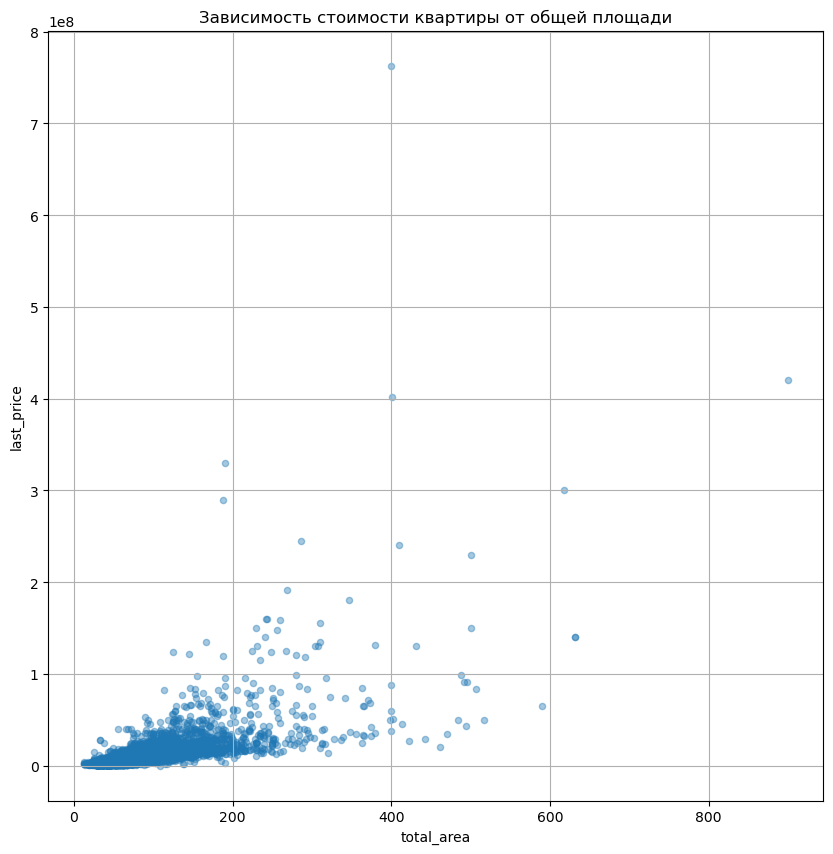

In [98]:
data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.4,
          grid=True, figsize=(10, 10), title='Зависимость стоимости квартиры от общей площади')
plt.show()

Отобразим вертикальную ось в логарифмическом масштабе:

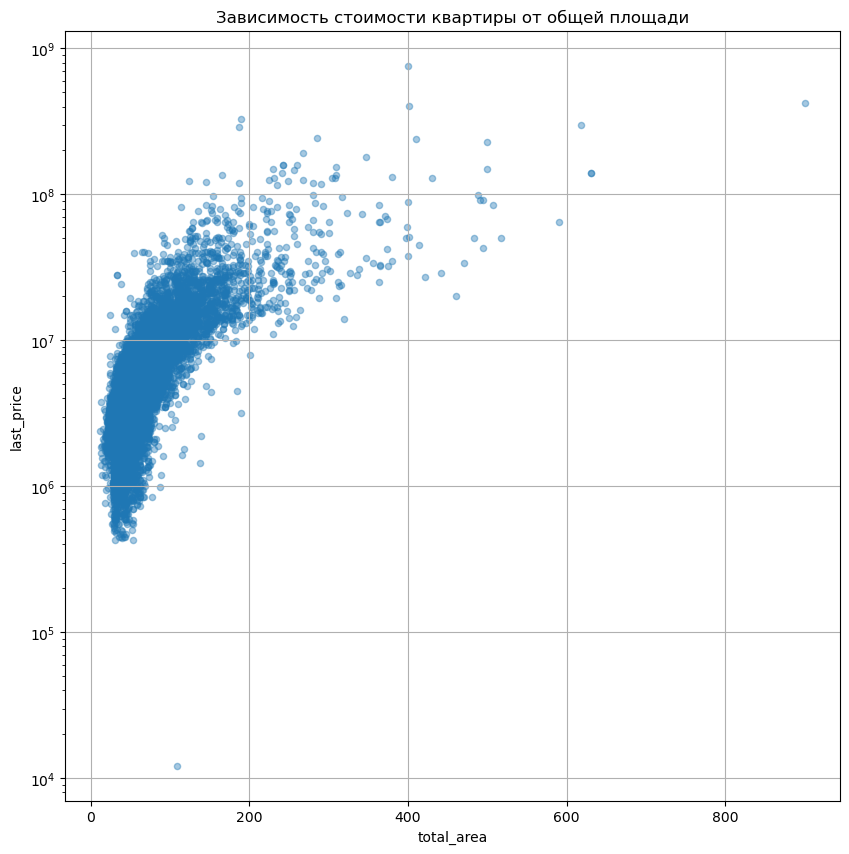

In [99]:
data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.4, grid=True,
          figsize=(10, 10), logy=True, title='Зависимость стоимости квартиры от общей площади')
plt.show()

Из этих двух графиков сразу видно, что есть отдельные квартиры, сильно выбивающиеся по стоимости из общей зависимости. И если с квартирами с запредельно высокой стоимостью сделать ничего нельзя (на стоимость могут влиять иные факторы, не указанные в датафрейме), то вот стоимость квартиры 8793 можно заменить на среднерыночную по СПб.

Сначала посмотрим на коэффициент корреляции между площадью и стоимостью для квартир в СПб:

In [100]:
filter_spb = data['locality_name'] == 'Санкт-Петербург' # фильтр на название Санкт-Петербург
data[filter_spb]['total_area'].corr(data[filter_spb]['last_price'])

0.6571875752588268

Думаю, что с таким коэффициентом можно использовать среднерыночную стоимость для квартиры 8793. Чтобы посчитать среднюю стоимость квартиры с площадью 109 м$^2$, сделаем выборку для квартир от 100 до 118 м$^2$, расположенных в СПб:

In [101]:
filter_spb_110 = data['total_area'] <=118 # фильтр на площадь меньше 118
filter_spb_108 = data['total_area'] >=100 # фильтр на площадь больше 100
filter_spb_not_8793 = data.index != 8793 # фильтр на индекс 8793

In [102]:
flats_spb_108_110 = data[filter_spb & filter_spb_110 & filter_spb_108 & filter_spb_not_8793] # тут сохраним выборку квартир
print(f'Количество квартир, удовлетворяющих выборке: {len(flats_spb_108_110.index)}')

Количество квартир, удовлетворяющих выборке: 698


Посчитаем среднее и медиану:

In [103]:
flats_spb_108_110_mean, flats_spb_108_110_med = mean_med(flats_spb_108_110, 'last_price')

Среднее арифметическое: 14206435.086
Медиана: 12700000.0


Выведем гистограмму распределения числа квартир от стоимости:

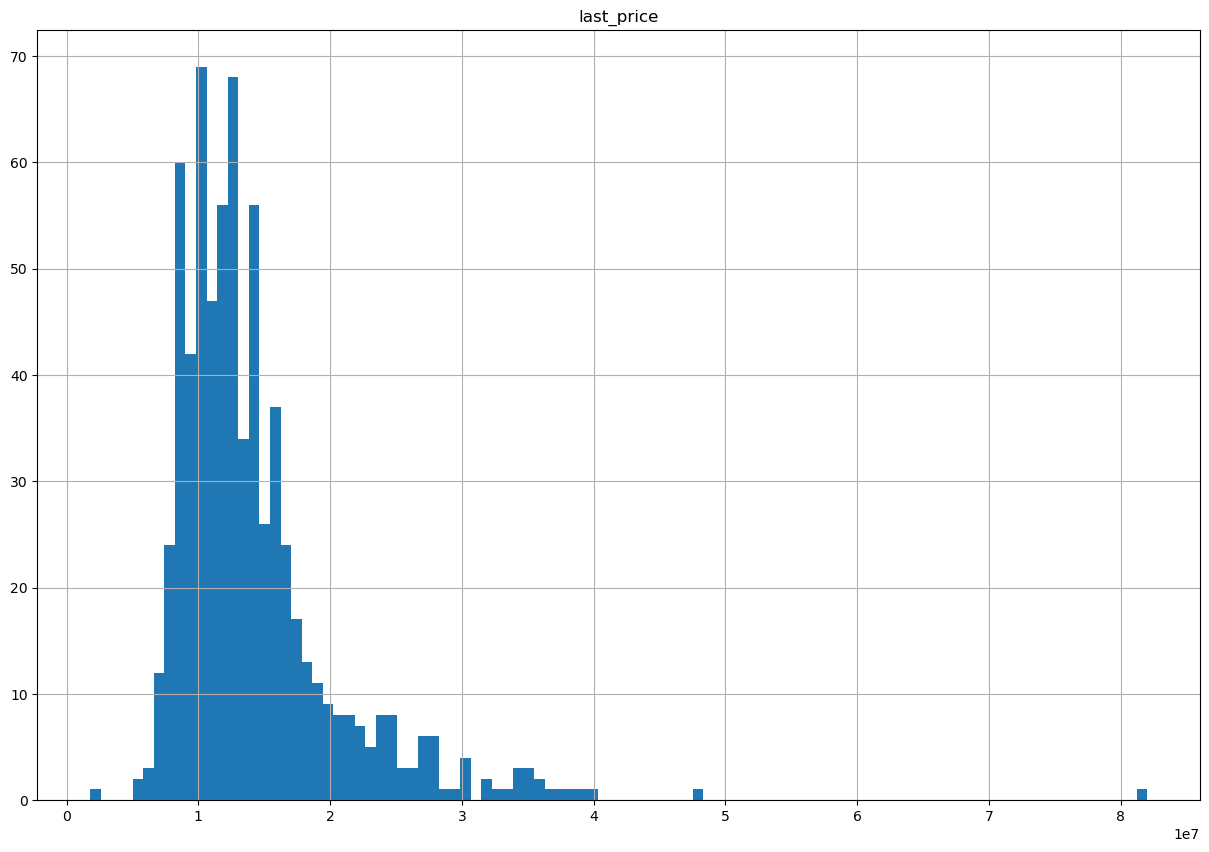

In [104]:
flats_spb_108_110.hist('last_price', bins=100, figsize=(15, 10))
plt.show()

Гистограмма выглядит довольно правдоподобно и похожа на распределение Пуассона. Решено заменить аномальное значение стоимости квартиры 8793 на среднюю стоимость квартир в СПб с площадью от 100 до 118 м$^2$

In [105]:
data.loc[8793, 'last_price'] = flats_spb_108_110_mean

Проверим, как данная корректировка повлияла на показатели:

In [106]:
flats_spb_108_110_upd = data[filter_spb & filter_spb_110 & filter_spb_108]
print(f'Количество квартир, удовлетворяющих выборке: {len(flats_spb_108_110_upd.index)}')
print('Новая стоимость квартиры 8793:', data.loc[8793, 'last_price'])
mean_med(flats_spb_108_110_upd, 'last_price')

Количество квартир, удовлетворяющих выборке: 699
Новая стоимость квартиры 8793: 14206435.086
Среднее арифметическое: 14206435.086
Медиана: 12700000.0


(14206435.086, 12700000.0)

Как видим, данная корректировка не повлияла на общие показатели. Замена оправдана.

#### Замена неявных дубликатов в столбце `locality_name`

Выведем уникальные значения столбца `locality_name`:

In [107]:
data['locality_name'].value_counts().sort_index()

locality_name
Бокситогорск             16
Волосово                 36
Волхов                  111
Всеволожск              398
Выборг                  237
                       ... 
село Путилово             2
село Рождествено          3
село Русско-Высоцкое      9
село Старая Ладога        2
село Шум                  1
Name: count, Length: 365, dtype: int64

Слишком много строк. Используем to_string(), чтобы вывести все уникальные названия насленных пунктов.

In [108]:
#with pd.set_option('display.max_rows', None):
print(data['locality_name'].value_counts().sort_index().to_string())

locality_name
Бокситогорск                                                  16
Волосово                                                      36
Волхов                                                       111
Всеволожск                                                   398
Выборг                                                       237
Высоцк                                                         4
Гатчина                                                      307
Зеленогорск                                                   24
Ивангород                                                     28
Каменногорск                                                  13
Кингисепп                                                    104
Кириши                                                       125
Кировск                                                       84
Колпино                                                      338
Коммунар                                                      89
Красное Сел

Визуальный анализ показал, что есть повторяющиеся населенные пункты, у которых различается написание слова "посёлок" - в некоторых случаях буква ё заменена на е. Исправим это:

In [109]:
data['locality_name'] = data['locality_name'].str.replace('поселок', 'посёлок')

Повторно выведем все названия:

In [110]:
print(data['locality_name'].value_counts().sort_index().to_string())

locality_name
Бокситогорск                                                  16
Волосово                                                      36
Волхов                                                       111
Всеволожск                                                   398
Выборг                                                       237
Высоцк                                                         4
Гатчина                                                      307
Зеленогорск                                                   24
Ивангород                                                     28
Каменногорск                                                  13
Кингисепп                                                    104
Кириши                                                       125
Кировск                                                       84
Колпино                                                      338
Коммунар                                                      89
Красное Сел

Также есть дубли у названий, содержащих слова "при железнодорожной станции" и "станции". Заменим "при железнодорожной станции" на "станции":

In [111]:
data['locality_name'] = data['locality_name'].str.replace('при железнодорожной станции', 'станции')

Повторим вывод:

In [112]:
print(data['locality_name'].value_counts().sort_index().to_string())

locality_name
Бокситогорск                                                  16
Волосово                                                      36
Волхов                                                       111
Всеволожск                                                   398
Выборг                                                       237
Высоцк                                                         4
Гатчина                                                      307
Зеленогорск                                                   24
Ивангород                                                     28
Каменногорск                                                  13
Кингисепп                                                    104
Кириши                                                       125
Кировск                                                       84
Колпино                                                      338
Коммунар                                                      89
Красное Сел

Попробуем пройтись по отсортированному списку с названиями и найти неявные дубликаты, сравнивая попарно соседние названия. В ходе сравнения будем проверять число отличающихся символов в парах. Если это число меньше 2, то выведем такие названия на экран.

In [113]:
names_sorted = list(data['locality_name'].value_counts().sort_index().index)

In [114]:
def compare(name_1, name_2):
    n = 0
    for x, y in zip(name_1, name_2):
        if x == y:
            n += 1
        else:
            n = 0
    if n >= 2:
        print(name_1, '---->', name_2 )
    
for i in range(0, len(names_sorted)-1):
    compare(names_sorted[i], names_sorted[i+1])

деревня Бор ----> деревня Борисова Грива
деревня Калитино ----> деревня Кальтино
деревня Оржицы ----> деревня Парицы
деревня Старая ----> деревня Старая Пустошь
деревня Терпилицы ----> деревня Тихковицы
деревня Яльгелево ----> деревня Ям-Тесово
посёлок Гаврилово ----> посёлок Гарболово
посёлок Глебычево ----> посёлок Гончарово
посёлок Жилгородок ----> посёлок Жилпосёлок
посёлок Репино ----> посёлок Романовка
посёлок Тёсово-4 ----> посёлок Углово
посёлок станции Громово ----> посёлок станции Корнево


Из полученных результатов возможным дубликатом является пара "деревня Калитино ----> деревня Кальтино". Поиск на Яндекс-картах показал, что в ЛО существуют обе таких деревни. Таким образом, это не дубликаты, а две разных деревни. Оставляем без изменений.

После всех проведенных манипуляций проверим, сколько осталось уникальных названий:

In [115]:
data['locality_name'].nunique()

329

Как видно, число уникальных названий уменьшилось с 365 до 329 шт.

Также выведем все уникальные названия и число их повторений в датафрейме:

In [116]:
print(data['locality_name'].value_counts().to_string())

locality_name
Санкт-Петербург                                            15721
посёлок Мурино                                               556
посёлок Шушары                                               440
Всеволожск                                                   398
Пушкин                                                       369
Колпино                                                      338
посёлок Парголово                                            327
Гатчина                                                      307
деревня Кудрово                                              299
Выборг                                                       237
Петергоф                                                     201
Сестрорецк                                                   183
Красное Село                                                 178
Кудрово                                                      173
деревня Новое Девяткино                                      144
Сертолово  

После выполненных операций считаем, что неявных дубликатов названий не осталось.

#### Выводы по выполненной предобработке данных

Выполнены замены пропусков там, где это возможно. Скорректированы некоторые аномальные значения. Изменены типы некоторых столбцов. Добавлен новый столбец `geo_data`, который показывает степень заполненности геоданных для каждой квартиры.

Посмотрим на общую информацию о таблице после проведенной предобработки данных:

In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  Int32         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

In [118]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
total_images,23699.0,9.858475,0.0,6.0,9.0,14.0,50.0,5.682529
last_price,23699.0,6542147.710118,430000.0,3400000.0,4650000.0,6800000.0,763000000.0,10887044.48732
total_area,23699.0,60.348651,12.0,40.0,52.0,69.9,900.0,35.654083
first_day_exposition,23699,2017-11-08 21:55:18.975484160,2014-11-27 00:00:00,2017-05-12 12:00:00,2017-12-12 00:00:00,2018-08-26 00:00:00,2019-05-03 00:00:00,NaN
rooms,23699.0,2.070636,0.0,1.0,2.0,3.0,19.0,1.078405
ceiling_height,23699.0,2.717392,2.5,2.6,2.7,2.7,6.0,0.217101
floors_total,23699.0,10.671463,1.0,5.0,9.0,16.0,60.0,6.595802
living_area,23699.0,34.566326,4.6,19.0,30.0,42.1,409.7,22.324617
floor,23699.0,5.892358,1.0,2.0,4.0,8.0,33.0,4.885249
kitchen_area,23699.0,10.578633,1.71,7.0,9.1,12.0,112.0,6.102328


In [119]:
data.describe(include=['object', 'bool'])

,is_apartment,studio,open_plan,locality_name,geo_data
count,23699,23699,23699,23699,23699
unique,2,2,2,329,3
top,False,False,False,Санкт-Петербург,Not_enough
freq,23649,23550,23632,15721,13364


Пропуски сохранились только в столбцах, относящихся к геоданным. Каких-то аномальных значений не наблюдается.

### Добавьте в таблицу новые столбцы

В данном разделе будут добавлены следующие столбцы:
- цена одного квадратного метра, округленная до двух знаков после запятой
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)
- месяц публикации объявления
- год публикации объявления
- тип этажа квартиры (значения — «первый», «последний», «другой»)
- расстояние до центра города в километрах (переведите из м в км и округлите до ближайших целых значений)

Присвоим каждому столбцу следующее название:
- `price_per_metr`
- `day_week_exposition`
- `month_exposition`
- `year_exposition`
- `floor_type`
- `city_center_km`

#### Расчет цены за метр

Расчет цены за метр определим как отношение стоимости квартиры к общей площади этой квартиры:

In [120]:
data['price_per_metr'] = np.round(data['last_price'] / data['total_area'], 2)

In [121]:
data['price_per_metr'].describe()

count    2.369900e+04
mean     9.942715e+04
std      5.030307e+04
min      7.962960e+03
25%      7.659966e+04
50%      9.500000e+04
75%      1.142593e+05
max      1.907500e+06
Name: price_per_metr, dtype: float64

#### Определение дня недели, месяца и года публикации объявления

Воспользуемся встроенными методами pandas для определения требуемых величин.

In [122]:
data['day_week_exposition'] = data['first_day_exposition'].dt.dayofweek

In [123]:
data['day_week_exposition'].value_counts()

day_week_exposition
3    4295
1    4183
4    4000
2    3974
0    3612
5    1936
6    1699
Name: count, dtype: int64

Даа, по выходным заниматься выставлением квартиры на продажу мало кто хочет)

In [124]:
data['month_exposition'] = data['first_day_exposition'].dt.month

In [125]:
data['month_exposition'].value_counts()

month_exposition
2     2640
3     2587
4     2379
11    2371
10    2127
9     1981
6     1760
8     1744
7     1695
12    1641
1     1500
5     1274
Name: count, dtype: int64

In [126]:
data['year_exposition'] = data['first_day_exposition'].dt.year

In [127]:
data['year_exposition'].value_counts()

year_exposition
2018    8519
2017    8190
2019    2879
2016    2783
2015    1191
2014     137
Name: count, dtype: int64

#### Определение типа этажа

Напишем функцию, которая в зависимости от номера этажа будет выдавать одно из трех требуемых значений.

In [128]:
def floor_type(row):
    try:
        if row['floor'] < row['floors_total']:
            if row['floor'] > 1:
                return 'Другой'
            else:
                return 'Первый'
        else:
            return 'Последний'
    except Exception:
        print(Exception)

Применяем функцию к новому столбцу:

In [129]:
data['floor_type'] = data.apply(floor_type, axis=1)

In [130]:
data['floor_type'].value_counts()

floor_type
Другой       17363
Последний     3447
Первый        2889
Name: count, dtype: int64

#### Определение расстояния от квартиры до центра в км

In [131]:
data['city_center_km'] = np.round(data['city_centers_nearest'] / 1000, 0)

In [132]:
data['city_center_km'].value_counts()

city_center_km
12.0    1607
15.0    1568
13.0    1457
14.0    1279
16.0    1265
        ... 
62.0       1
59.0       1
45.0       1
61.0       1
63.0       1
Name: count, Length: 61, dtype: int64

#### Выводы по данному разделу

Добавлены новые столбцы, необходимые для последующего исследования данных.

Выведем первые пять строк обновленного датафрейма, чтобы показать новые столбцы:

In [133]:
data.head().T

,0,1,2,3,4
total_images,20,7,10,0,2
last_price,13000000.0,3350000.0,5196000.0,64900000.0,10000000.0
total_area,108.0,40.4,56.0,159.0,100.0
first_day_exposition,2019-03-07 00:00:00,2018-12-04 00:00:00,2015-08-20 00:00:00,2015-07-24 00:00:00,2018-06-19 00:00:00
rooms,3,1,2,3,2
ceiling_height,2.7,2.7,2.7,2.7,3.03
floors_total,16,11,5,14,14
living_area,51.0,18.6,34.3,89.805585,32.0
floor,8,1,4,9,13
is_apartment,False,False,False,False,False


### Проведите исследовательский анализ данных

Необходимо построить гистограммы распределения для ряда параметров. Запишем названия параметров (столбцов), по которым требуется выполнить исследование, в отдельную переменную:

In [134]:
parametr_list = ['total_area', 'living_area', 'kitchen_area', 'last_price',
                'rooms', 'ceiling_height', 'floor_type', 'floors_total',
                'city_centers_nearest', 'parks_nearest']

Выведем гистограммы в цикле для их предварительного просмотра. После этого построим каждую гистограмму отдельно, для подробного анализа.

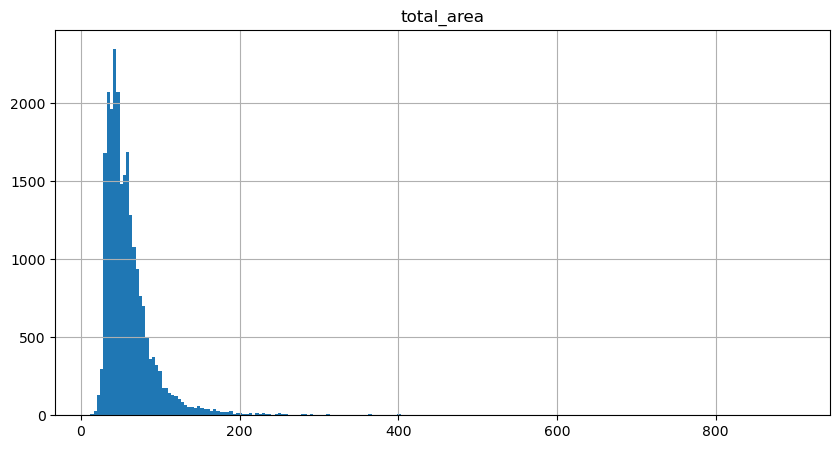

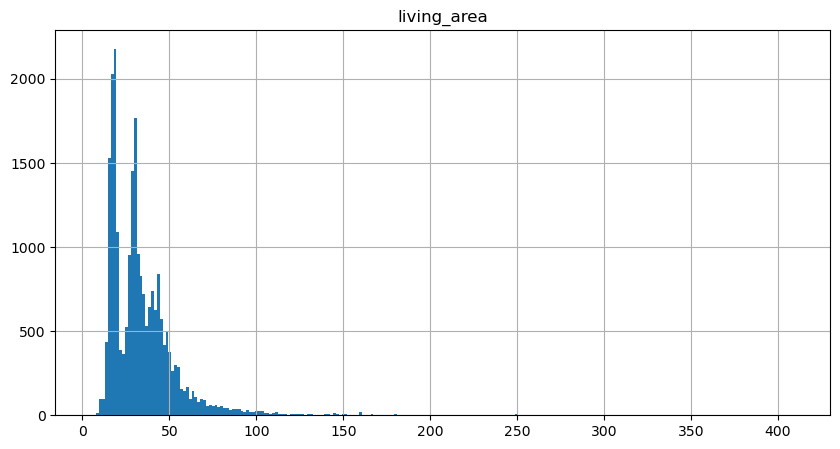

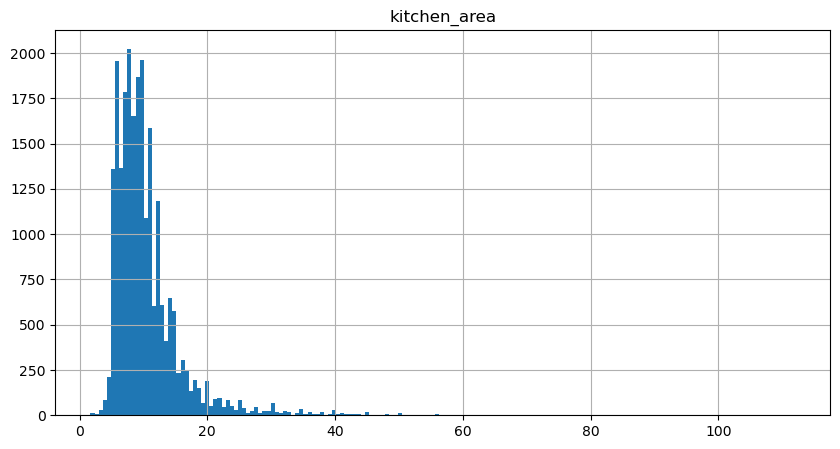

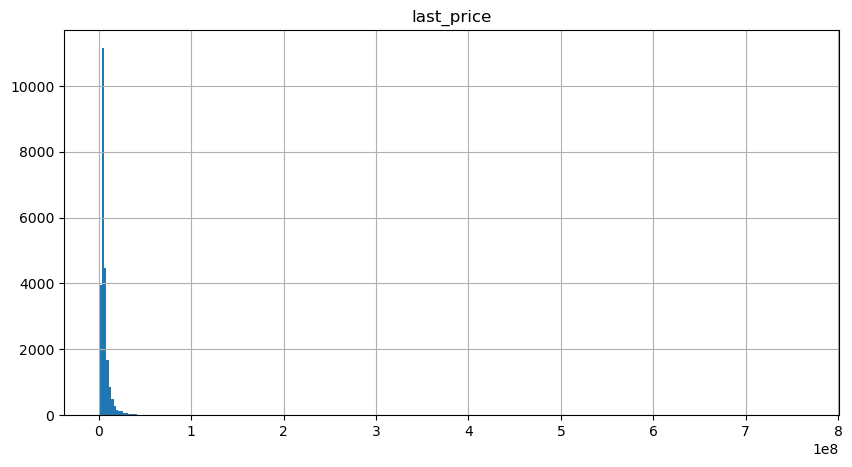

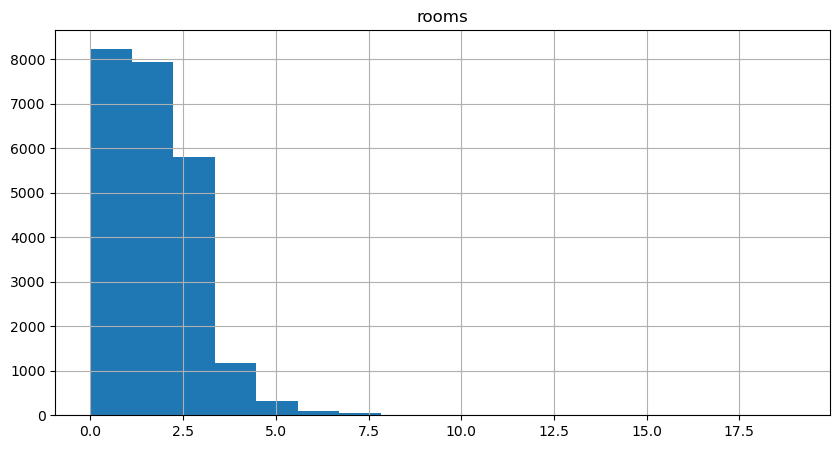

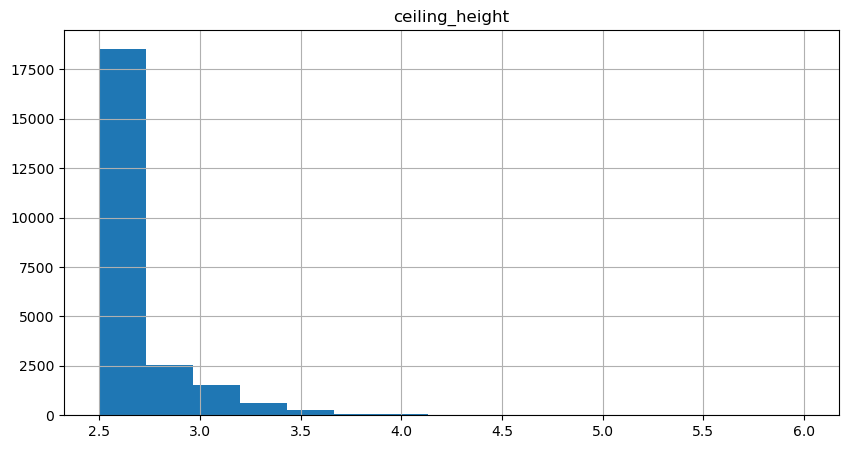

floor_type <class 'Exception'>


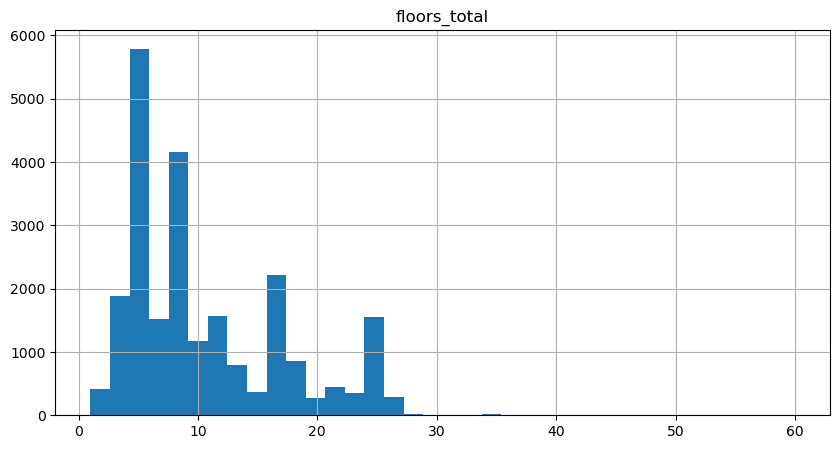

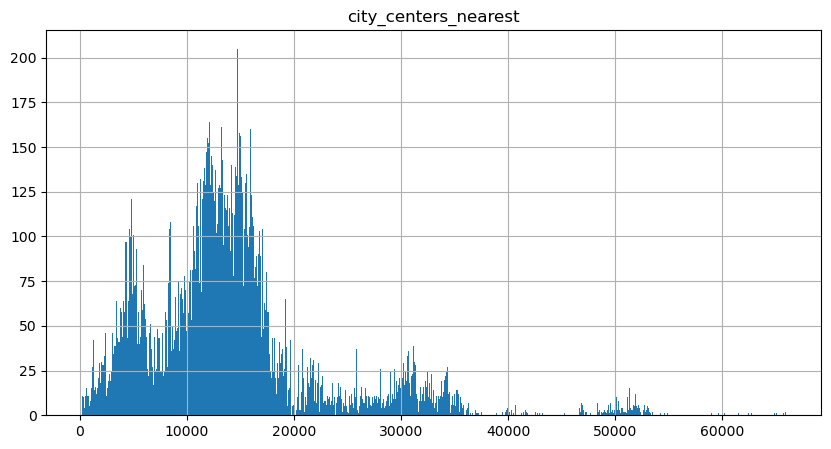

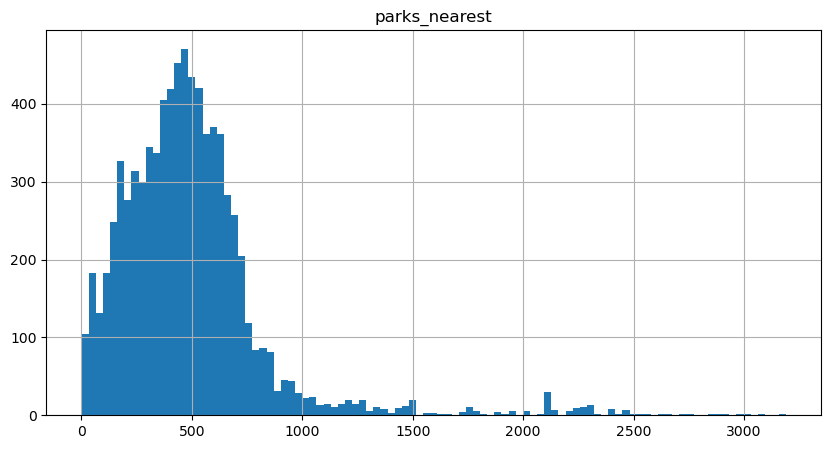

In [135]:
for col in parametr_list:
    try:
        if data[col].nunique() > 100:
            bins = data[col].nunique() // 10
        else:
            bins = data[col].nunique()
        data.hist(col, bins=bins, figsize=(10, 5))
        plt.show()
        
    except Exception:
        print(col, Exception)

По какой-то причине не отобразилась гистограмма для столбца `floor_type`.

In [136]:
type(data['floor_type'][0])

str

Метод hist не может использовать тип данных str, поэтому для столбца `floor_type` гистограмму так просто не построить. Попробуем сделать так:

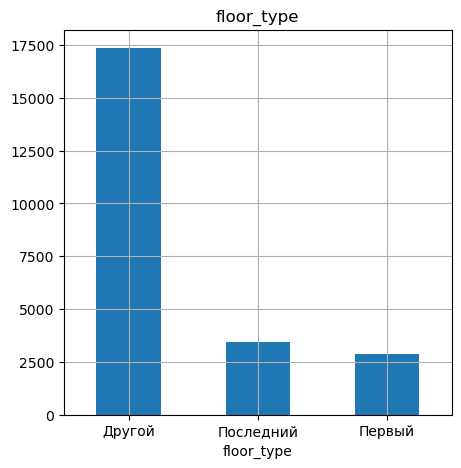

In [137]:
data['floor_type'].value_counts().plot(kind='bar', title='floor_type', figsize=(5, 5), grid=True, rot=0)
plt.show()

#### Анализ полученных гистограмм

##### Распределение данных в столбце `total_area`

Предварительный анализ полученной гистограммы показал, что число квартир, площадь которых превышает 200 м$^2$, совсем невелико. Поэтому можно обрезать отображение по оси Х до 200.

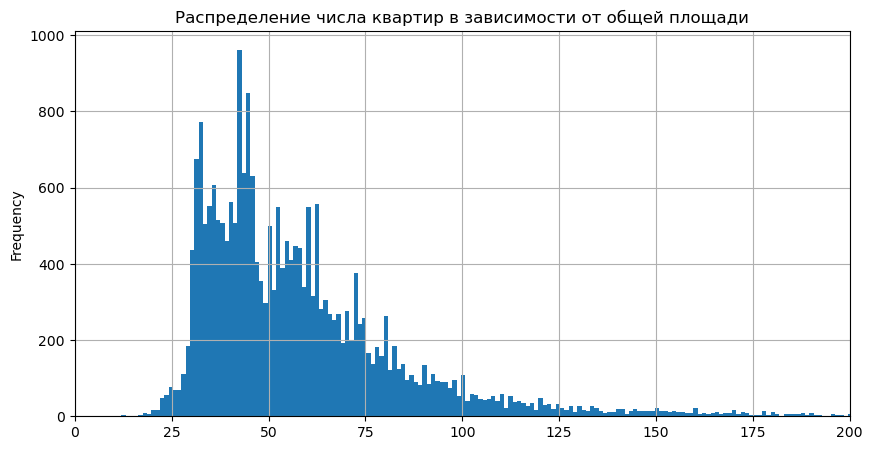

In [138]:
data['total_area'].plot(kind='hist', bins=800,
                        figsize=(10, 5), xlim=(0, 200),
                        grid=True, title='Распределение числа квартир в зависимости от общей площади')
plt.show()

В целом, полученный график выглядит правдоподобно. Из графика видно, что основное число квартир приходится на квартиры с площадью от 30 до 75 м$^2$. Выделяются два пика у значений ~30 и ~45 м$^2$

Отдельно посмотрим на число квартир с площадью больше 200 м$^2$:

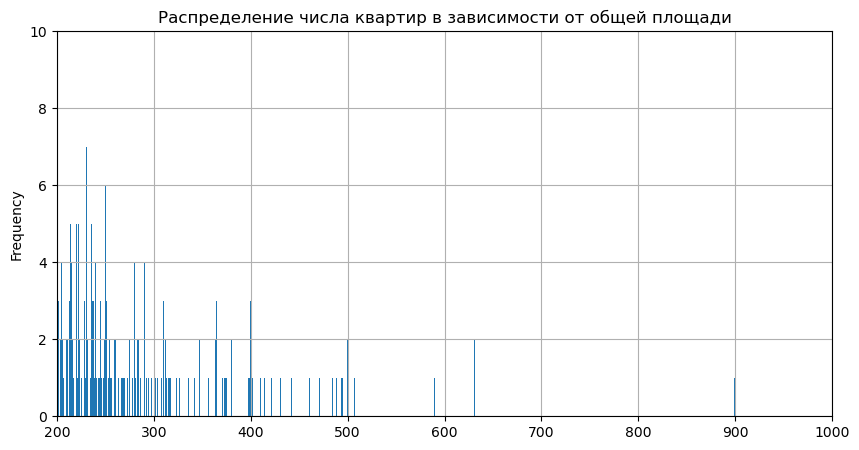

In [139]:
data['total_area'].plot(kind='hist', bins=1000, figsize=(10, 5), ylim=(0, 10), xlim=(200, 1000), grid=True,
                        title='Распределение числа квартир в зависимости от общей площади')
plt.show()


Как и было сказано выше, число квартир с такой большой площадью совсем небольшое.

**Вывод**

Данные по общей площади квартир не содержат каких-либо аномалий. Распределение числа квартир от общей площади похоже на распределение Пуассона, что говорит о достоверности исходных данных в этом столбце.

##### Распределение данных в столбце `living_area`

По аналогии со столбцом `total_area` обрежем ось Х по значению 200. Также при анализе помним, что у нескольких квартир мы скорректировали величину жилой площади, заменив ее на 20% от общей (раздел 2.3.10 отчета).

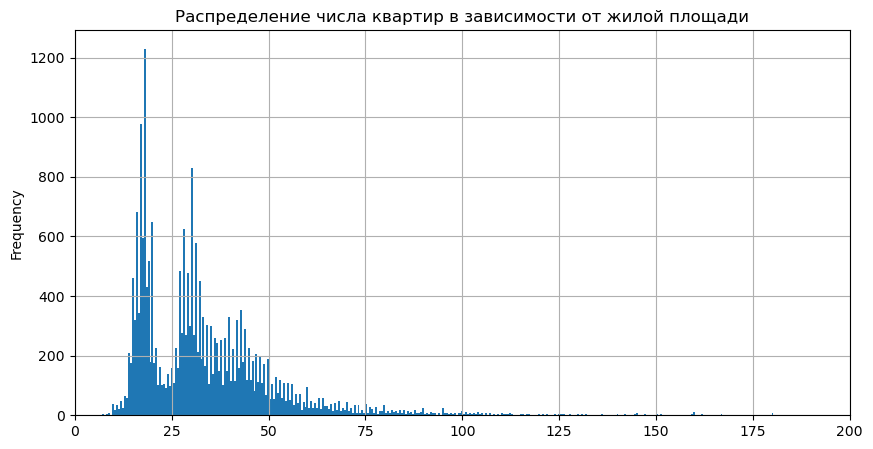

In [140]:
data['living_area'].plot(kind='hist', bins=800, figsize=(10, 5), xlim=(0, 200), grid=True, 
                         title='Распределение числа квартир в зависимости от жилой площади')
plt.show()

Явно выделяются два пика. Отобразим их детальнее:

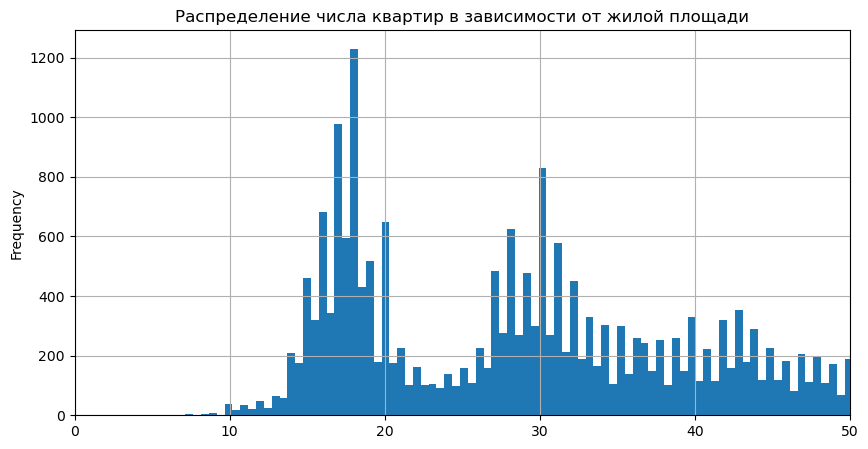

In [141]:
data['living_area'].plot(kind='hist', bins=800, figsize=(10, 5), xlim=(0, 50), grid=True, 
                         title='Распределение числа квартир в зависимости от жилой площади')
plt.show()

По всей видимости, эти два выброса напрямую связаны с двумя обнаруженными выбросами из предыдущей гистограммы. Чтобы убедиться в этом, проверим корреляцию между параметрами `living_area` и `total_area`:

In [142]:
print('Корреляция между параметрами living_area и total_area:', data['total_area'].corr(data['living_area']))

Корреляция между параметрами living_area и total_area: 0.9462479903338813


Очень высокая корреляция. Построим зависимость `living_area` от `total_area`:

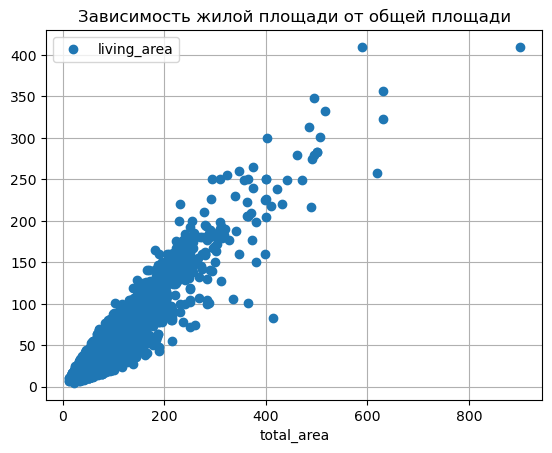

In [143]:
data.plot(x='total_area', y='living_area', style='o', grid=True,
                         title='Зависимость жилой площади от общей площади')
plt.show()

**Вывод**

Данные по жилой площади квартир не содержат каких-либо аномалий после выполненной корректировки на этапе предобработки. Также наблюдается сильная корреляция между данными в этом столбце и данными в столбце с общей площадью.

##### Распределение данных в столбце `kitchen_area`

По аналогии с предыдущими разделами обрежем ось Х, только в этот раз по значению 40. Также при анализе помним, что у нескольких квартир мы скорректировали величину площади кухни на 6% от общей (раздел 2.3.11 отчета).

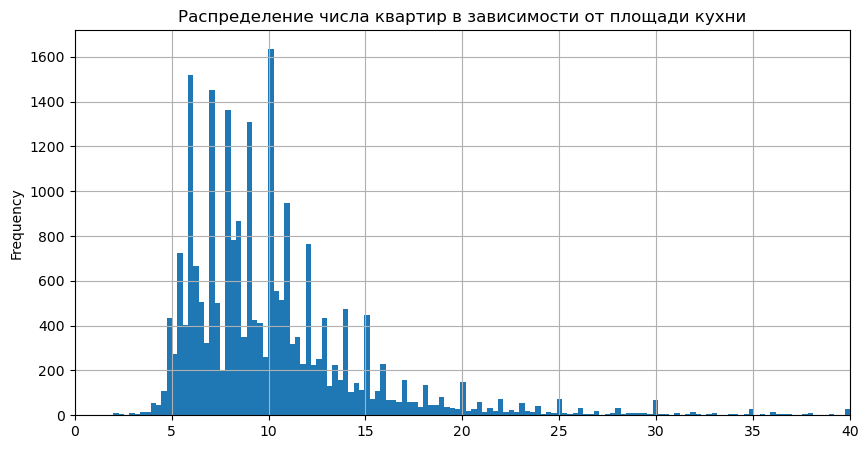

In [144]:
data['kitchen_area'].plot(kind='hist', bins=400, figsize=(10, 5), xlim=(0, 40), grid=True,
                         title='Распределение числа квартир в зависимости от площади кухни')
plt.show()

Гистограмма выглядит довольно необычно - примерно через равные промежутки наблюдаются выраженные всплески числа квартир с определенной площадью кухни. При этом основание графика все же напоминает распределение Пуассона.

Попробуем построить гистограмму, отображающую % площади кухни от общей площади квартиры.

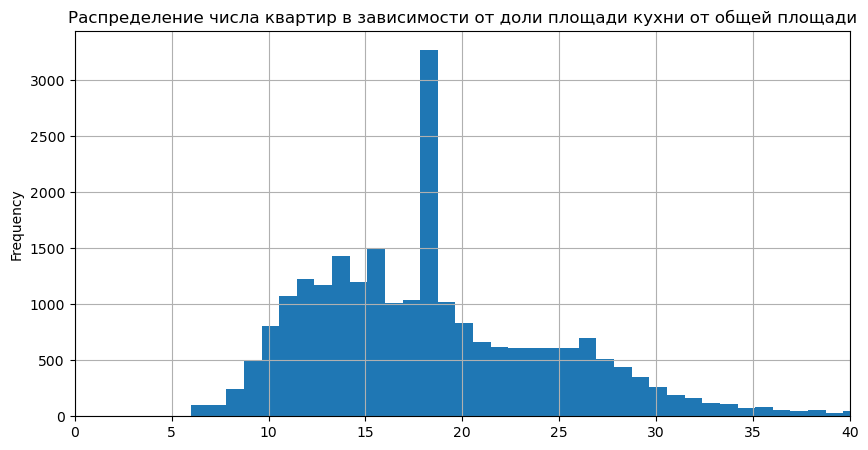

In [145]:
data_kitchen_percent = data['kitchen_area'] / data['total_area'] * 100
data_kitchen_percent.plot(kind='hist', bins=80, figsize=(10, 5), xlim=(0, 40), grid=True,
                         title='Распределение числа квартир в зависимости от доли площади кухни от общей площади')
plt.show()

Очень высокий пик для значения между 15 и 20%. Определим что это за процент:

In [146]:
data_kitchen_percent.value_counts()

18.737700    2201
20.000000     223
25.000000     195
16.666667     168
18.750000     133
             ... 
11.284514       1
10.037879       1
31.073446       1
11.216216       1
30.358306       1
Name: count, Length: 10233, dtype: int64

Итак, среди всех квартир сильно выделяется 2201 квартир, у которых процент площади кухни от общей составляет 18.7%. Возможно, что выбросы на предыдущей гистограмме как раз и являются частью этих 2201 квартир. Попробуем это выяснить. Для этого из переменной `data_kitchen_percent` сделаем выборку тех квартир, у которых % площади = 18.7%:

In [147]:
data_kitchen_18 = (data_kitchen_percent == 18.737700)
data_kitchen_2201 = data.loc[data_kitchen_18]
data_kitchen_2201

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,geo_data,price_per_metr,day_week_exposition,month_exposition,year_exposition,floor_type,city_center_km
3,0,64900000.0,159.0,2015-07-24,3,2.70,14,89.805585,9,False,...,3,234.0,424,Filled,408176.10,4,7,2015,Другой,7.0
30,12,2200000.0,32.8,2018-02-19,1,2.70,9,18.525932,2,False,...,<NA>,NaN,63,Empty,67073.17,0,2,2018,Другой,NaN
37,10,1990000.0,45.8,2017-10-28,2,2.50,5,25.868527,1,False,...,<NA>,NaN,196,Empty,43449.78,5,10,2017,Первый,NaN
44,13,5350000.0,40.0,2018-11-18,1,2.70,22,22.592600,3,False,...,1,1152.0,0,Filled,133750.00,6,11,2018,Другой,12.0
59,15,6300000.0,46.5,2017-03-06,1,2.70,13,26.263897,13,False,...,0,NaN,336,Not_enough,135483.87,0,3,2017,Последний,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23655,1,2414306.0,40.5,2016-09-08,1,2.56,18,19.600000,10,False,...,<NA>,NaN,627,Empty,59612.49,3,9,2016,Другой,NaN
23663,12,6400000.0,88.0,2018-01-12,4,2.55,10,49.703720,1,False,...,2,844.0,59,Not_enough,72727.27,4,1,2018,Первый,14.0
23670,9,2450000.0,45.6,2018-02-08,1,2.80,9,25.755564,2,False,...,<NA>,NaN,45,Empty,53728.07,3,2,2018,Другой,NaN
23679,0,2500000.0,35.0,2017-12-08,1,2.70,9,19.768525,4,False,...,<NA>,NaN,45,Empty,71428.57,4,12,2017,Другой,NaN


Каких-то явных зависимостей для этой выборки квартир не видно. Пока что сложно сказать, чем вызвано наличие такого большого количества квартир, у которых % площади кухни от общей составляет 18.7%

**Вывод**

Наблюдаются ярко выраженные пики числа квартир для определенных значений площади кухни. Их причину установить не удалось. Также выявлено, что имеется ярко выраженное число квартир, у которых площадь кухни составляет 18.7% от общей площади квартиры. Причину наличия такого большого числа квартир, попадающих под этот критерий, также установить не удалось.

##### Распределение данных в столбце `last_price`

Выведем гистограмму в логарифмическом масшатбе для оси Х:

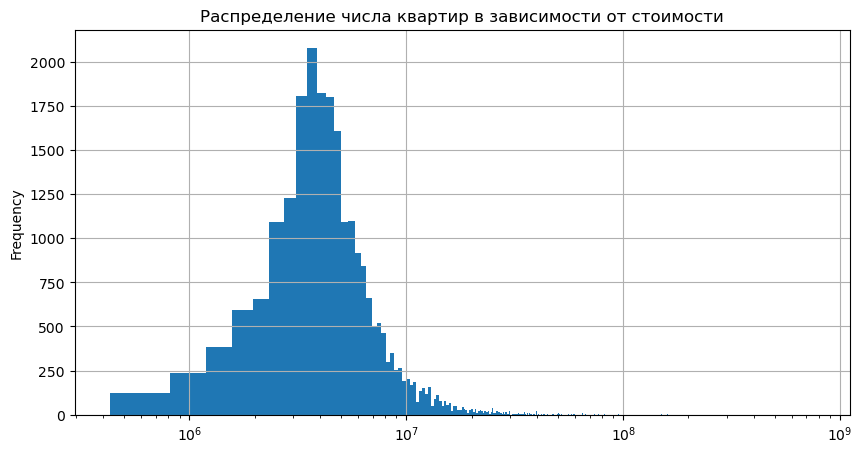

In [148]:
data['last_price'].plot(kind='hist', bins=2000, figsize=(10, 5), logx=True, grid=True,
                         title='Распределение числа квартир в зависимости от стоимости')
plt.show()

In [149]:
data['last_price'].describe()

count    2.369900e+04
mean     6.542148e+06
std      1.088704e+07
min      4.300000e+05
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

**Вывод**

Результат напоминает нормальное распределение. Каких-то аномальных значений не наблюдается.

##### Распределение данных в столбце `rooms`

Выведем гистограмму:

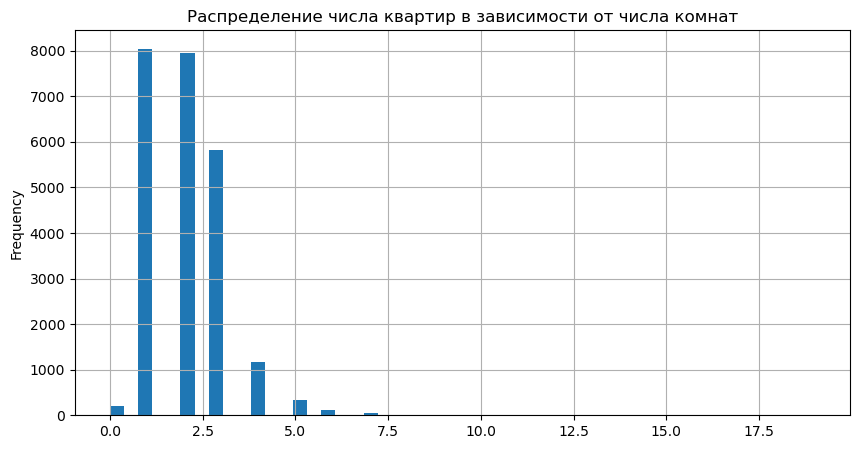

In [150]:
data['rooms'].plot(kind='hist', bins=50, figsize=(10, 5), grid=True,
                         title='Распределение числа квартир в зависимости от числа комнат')
plt.show()

Видно, что большинство квартир одно- или двухкомантные. Таких вариантов представлено примерно по 8000. После этого идут трехкомнатные - чуть меньше 6000 шт. С большим отставанием расположились четырехкомнатные - чуть больше 1000 шт. Доля остальных квартир совсем невелика. Также стоит обратить внимание на квартиры с нулевым числом комнат - их доля небольшая, но это однозначно можно принять за аномальные значения. Посмотрим, сколько таких квартир:

In [151]:
data[data['rooms'] == 0]['rooms'].count()

197

Как и было сказано в разделе 2.3.14 отчета, сделать что-то с этими аномальными данными нельзя. Считаем, что нулевое число комнат означает, что при выставлении квартиры на продажу действительное число комнат не было указано.

**Вывод**

Имеется 197 аномальных значений, с которыми нельзя что-либо сделать. Остальные данные выглядят корректно.

##### Распределение данных в столбце `ceiling_height`

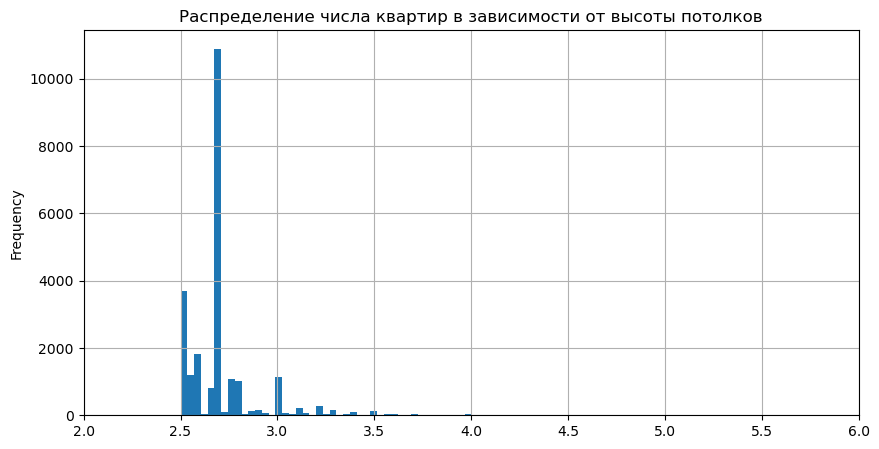

In [152]:
data['ceiling_height'].plot(kind='hist', bins=100, figsize=(10, 5), grid=True, xlim=(2, 6),
                         title='Распределение числа квартир в зависимости от высоты потолков')
plt.show()

При анализе данной гистограммы помним, что при проведении предобработки данных все пропуски и аномальные значения были заменены на величину медианы, равную 2.7м. Аномальными принимались величины, меньшие 2.5 м или большие 6 м (раздел 2.3.9 отчета).

**Вывод**

Как видим, наибольшее число квартир имеет высоту потолков ~2.7 м. Это связано с тем, что в исходных данных было порядка 9000 пропусков и все они были заменены на величину 2.7 м. Также имеется несколько пиков в диапазоне от 2.5 м до 2.7 м. Помимо этого, выделяется несколько пиковых значений с высотой более 2.7 м.

##### Распределение данных в столбце `floor_type`

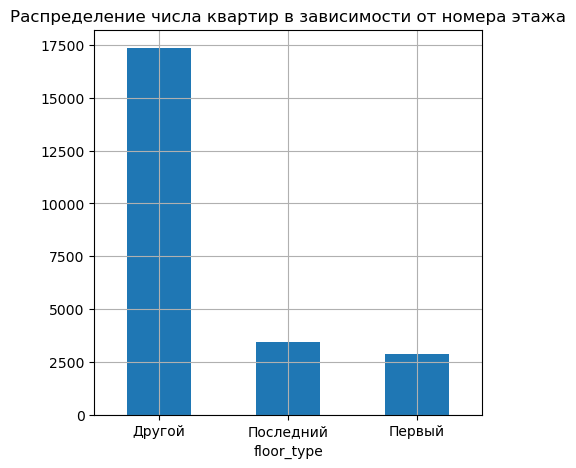

In [153]:
data['floor_type'].value_counts().plot(kind='bar', figsize=(5, 5), grid=True, rot=0,
                         title='Распределение числа квартир в зависимости от номера этажа')
plt.show()

**Вывод**

Как видим, наибольшее число продаваемых квартир расположено не на первом и не на последнем этаже дома и составляет около 17500 шт. Число квартир, расположенных на первом или последнем этаже примерно одинаково.

##### Распределение данных в столбце `floors_total`

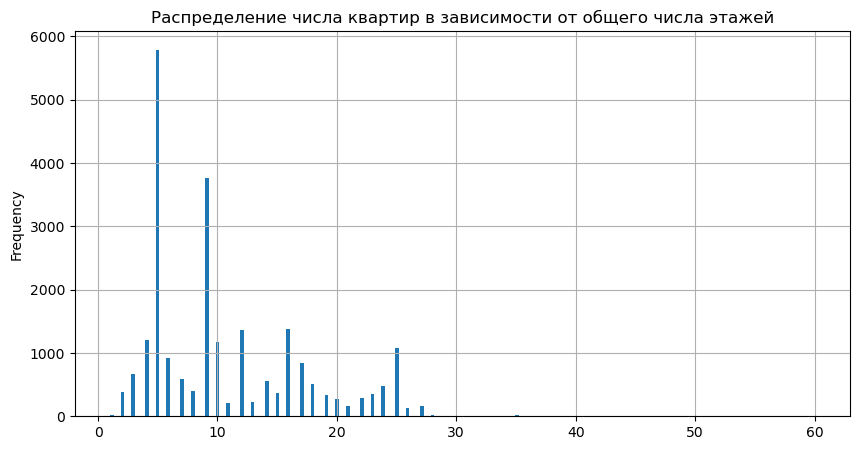

In [154]:
data['floors_total'].plot(kind='hist', bins=200, figsize=(10, 5), grid=True,
                         title='Распределение числа квартир в зависимости от общего числа этажей')
plt.show()

**Вывод**

Как видим, наибольшее число квартир расположено в пятиэтажных домах - порядка 5900 шт. После этого наибольшее число квартир встречается в девятиэтажных домах - около 3800 шт. Затем примерно по одинаковому количеству продаваемых квартир расположилось в 4, 10, 12, 16, 25 -этажных домах. Каких-то аномальных значений не наблюдается.

##### Распределение данных в столбце `city_centers_nearest`

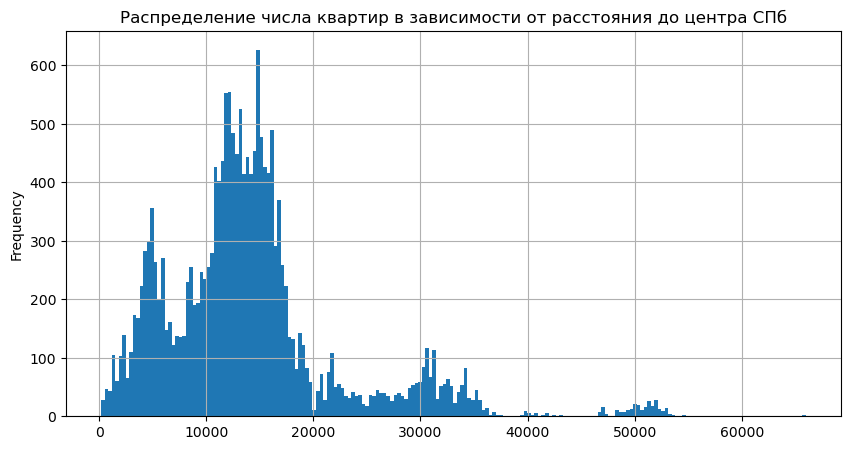

In [155]:
data['city_centers_nearest'].plot(kind='hist', bins=200, figsize=(10, 5), grid=True,
                         title='Распределение числа квартир в зависимости от расстояния до центра СПб')
plt.show()

По удаленности от центра города можно сказать следующее - есть явный пик числа квартир, расположенных на расстоянии около 3000 - 5000 м от центра. Затем следует еще больший пик на диапазоне от примерно 10000 до 17000 метров. После этого число квартир резко идет на спад. Наблюдаются небольшие пики на расстояниях порядка 22000 м, 30000 - 32000 м. Также есть определенное число квартир, расположенных на расстояниях около 40000 м, а затем идет отдельный пик на расстояниях от 47000 до 54000 м.

Такие разбросы квартир по удаленности говорят о следующем:
- основное число квартир, для которых есть геоданные, расположены в черте Санкт-Петербурга. При этом основная масса этих квартир приходится на спальные районы (расстояние 10 - 17 км). Также имеется довольно большое число предложений о продаже квартир, расположенных в центре города (расстояние от 0 до 8 км).
- имеется несколько небольших пиков, расположенных на значительном расстоянии от центра (30 км и более) - по всей видимости, это какие-то областные центры (небольшие городки), в которых продаются квартиры. Или же новые спальные районы, построенные на самом краю города.

Каких-то аномальных значений не наблюдается.

Посмтрим, как изменится гистограмма, если к ней применить фильтр по новому столбцу `geo_data` (напомню, что данный столбец принимает три значения - Filled, Not_enough, Empty):

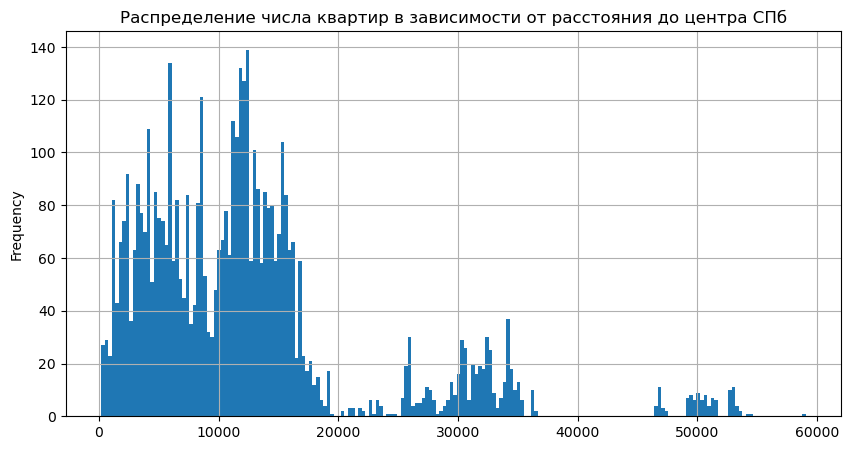

In [156]:
data[data['geo_data'] == 'Filled']['city_centers_nearest'].plot(kind='hist', bins=200, figsize=(10, 5), grid=True,
                         title='Распределение числа квартир в зависимости от расстояния до центра СПб')
plt.show()

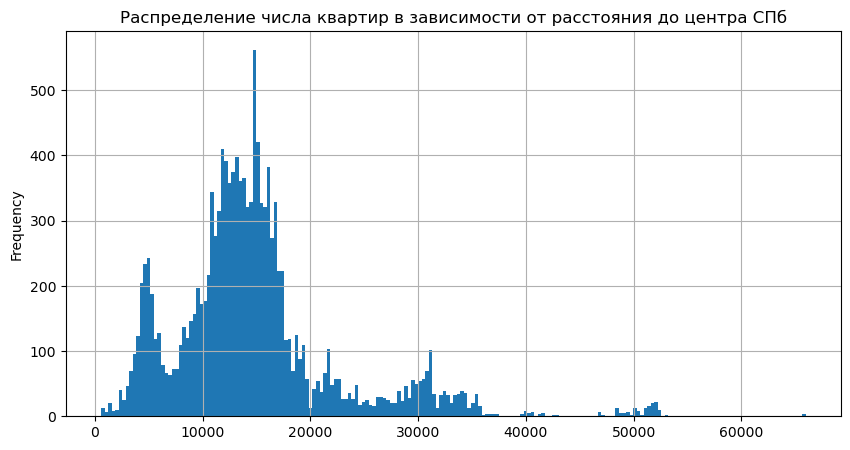

In [157]:
data[data['geo_data'] == 'Not_enough']['city_centers_nearest'].plot(kind='hist', bins=200, figsize=(10, 5), grid=True,
                         title='Распределение числа квартир в зависимости от расстояния до центра СПб')
plt.show()

В целом, обе гистограммы своей формой повторяют исходную, но при этом общее число квартир в каждой из них меньше, так как применена выборка.

**Вывод**

Аномальных данных не обнаружено. Из полученных гистограмм следует, что наибольшее число квартир с заполненными геоданными продается в пределах СПб и находятся в спальных районах.

##### Распределение данных в столбце `parks_nearest`

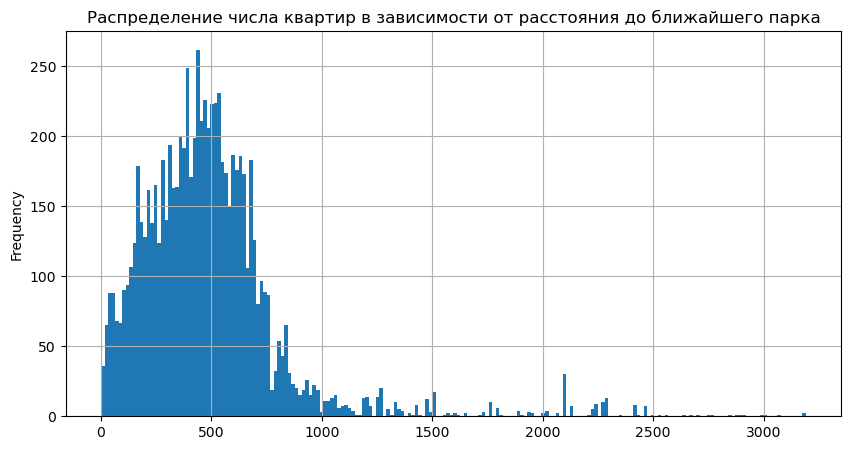

In [158]:
data['parks_nearest'].plot(kind='hist', bins=200, figsize=(10, 5), grid=True,
                         title='Распределение числа квартир в зависимости от расстояния до ближайшего парка')
plt.show()

**Вывод**

Из данного графика следует, что наибольшее число квартир, у которых есть геоданные по паркам, имеют рядом с собой парки на расстояниях от 0 до 700 м.

#### Изучение скорости продажи квартир

Перед построением гистограммы будем помнить, что в разделе 2.3.8 отчета все пропуски в столбце `days_exposition` были заменены на 0.

Построим гистограмму для параметра `days_exposition`:

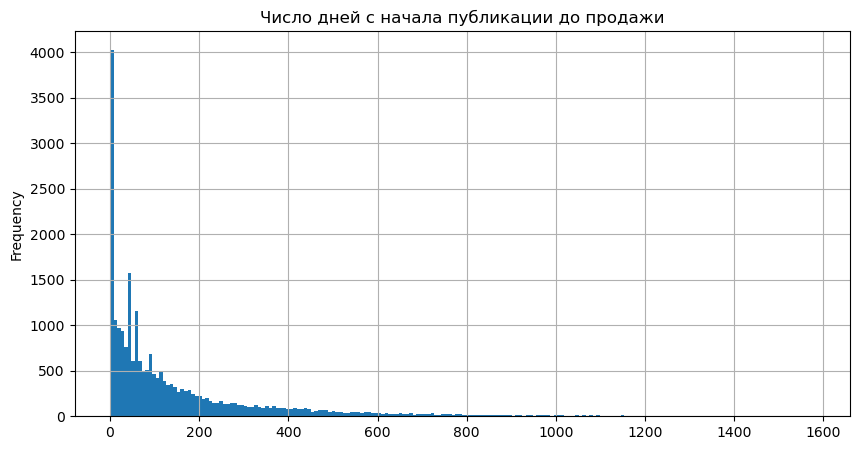

In [159]:
data['days_exposition'].plot(kind='hist', bins=200, figsize=(10, 5),
                             grid=True, title='Число дней с начала публикации до продажи')
plt.show()

Видно, что сильно выделяются квартиры с нулевыми значениями. Выведем их число и затем отбросим из общей выборки:

Общее число квартир: 23699
Число квартир с пропусками в столбце "days_exposition": 3181


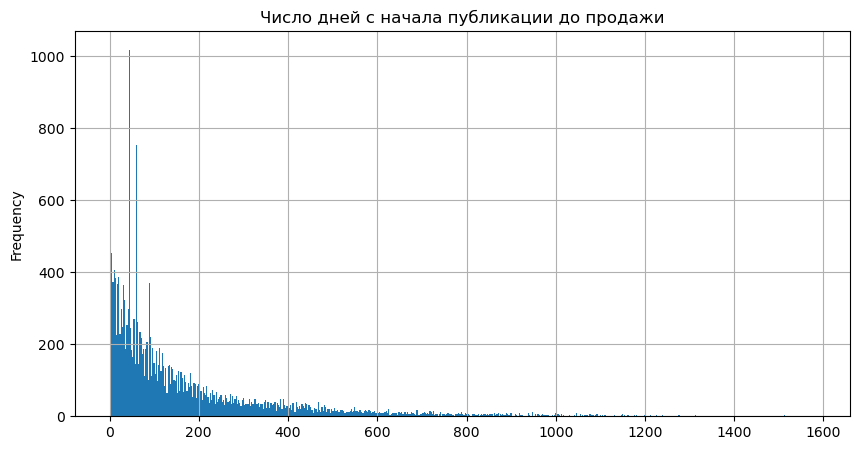

In [160]:
data_no_zero_days_exp = data[data['days_exposition'] != 0]
print('Общее число квартир:', len(data['days_exposition']))
print('Число квартир с пропусками в столбце "days_exposition":', len(data[data['days_exposition'] == 0]))

data_no_zero_days_exp['days_exposition'].plot(kind='hist', bins=600, figsize=(10, 5), 
                                              grid=True, title='Число дней с начала публикации до продажи')
plt.show()

Из графика видно, что в целом зависимость длительности продажи квартир от их числа имеет вид убывающей функции - напоминает гиперболу или убывающую экспоненту. При этом выделяется несколько пиковых значений. Рассмотрим их детальнее:

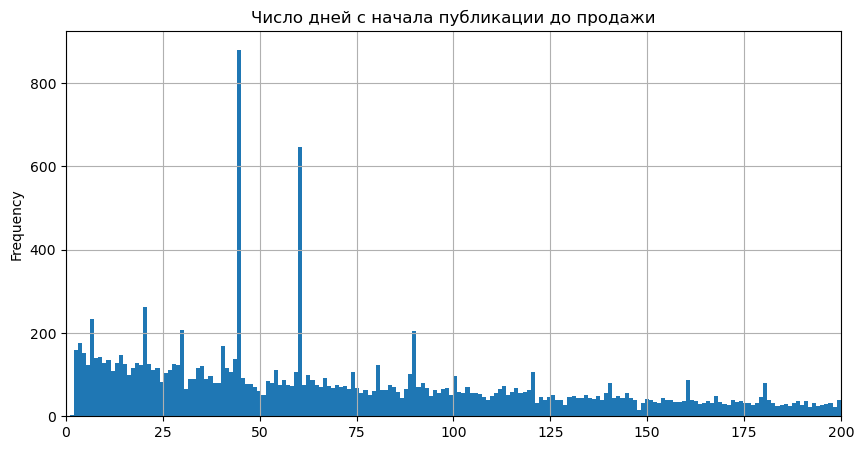

In [161]:
data_no_zero_days_exp['days_exposition'].plot(kind='hist', bins=1500, figsize=(10, 5), 
                                              grid=True, xlim=(0, 200), title='Число дней с начала публикации до продажи')
plt.show()

По гистограмме нельзя точно определить значения для пиков:

In [162]:
data_no_zero_days_exp['days_exposition'].value_counts().head(20)

days_exposition
45    880
60    538
7     234
30    208
90    204
4     176
3     158
5     152
14    148
9     143
8     139
20    139
44    138
11    135
18    129
13    128
10    127
15    126
28    126
22    125
Name: count, dtype: int64

Как видно, наибольшее число квартир было продано через 45 дней после публикации - 880 шт. Затем идут 538 квартир, проданных через 60 дней после публикации. После этого идут квартиры, проданные через неделю - 234 шт. И затем примерно поровну (208 и 204 шт) квартиры, проданные через 30 и через 90 дней соответственно.

Определим среднее и медиану:

In [163]:
mean_med(data_no_zero_days_exp, 'days_exposition')

Среднее арифметическое: 180.8886
Медиана: 95.0


(180.8886, 95.0)

Выведем дополнительные параметры, а также построим диаграмму размаха, чтобы сделать некоторые выводы о скорости продажи квартир.

In [164]:
data_no_zero_days_exp['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

<Axes: title={'center': 'Число дней с начала публикации до продажи'}>

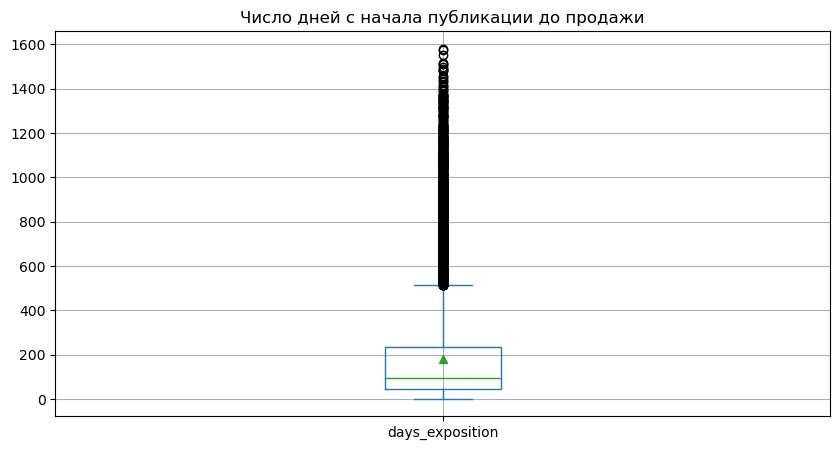

In [165]:
from matplotlib.cbook import boxplot_stats
data_no_zero_days_exp['days_exposition'].plot(kind='box', showmeans=True, figsize=(10, 5), 
                                              grid=True, title='Число дней с начала публикации до продажи')

In [166]:
boxplot_stats(data_no_zero_days_exp['days_exposition'])

[{'mean': 180.88863436982163,
  'iqr': 187.0,
  'cilo': 92.95037813120341,
  'cihi': 97.04962186879659,
  'whishi': 512,
  'whislo': 1,
  'fliers': array([558, 571, 615, ..., 721, 519, 602], dtype=int16),
  'q1': 45.0,
  'med': 95.0,
  'q3': 232.0}]

**Вывод**

Из полученных данных следует:
- из анализа были исключены 3181 квартир, так как по ним нет информации о дате продажи.
- половина из 20518 квартир были проданы менее, чем за 95 дней.
- в среднем, одна квартира продается за 181 день.
- 75% от общего числа квартир были проданы за 232 дня.
- имеются квартиры, длительность продажи которых может доходить до ~1600 дней.
- в качестве быстрых продаж можно назвать те, которые были совершены за первые 45 дней (1-ый квартиль), так как за это время проданы 25% от общего числа квартир.
- в качестве необычно долгих можно назвать те, длительность продажи которых превышает 512 Дней (верхняя граница уса).

#### Изучение факторов, больше всего влияющих на продажу квартир

Необходимо выяснить, как зависит цена от следующих факторов:
- общей площади
- жилой площади
- площади кухни
- количества комнат
- этажа, на котором расположена квартира (первый, последний, другой)
- даты размещения (день недели, месяц, год)

Для этого создадим переменную, содержащую названия соответствующих столбцов, и в цикле выведем предварительный график для каждой зависимости. После этого построим каждый график по отдельности для подробного анализа.

Также напишем функцию, которая будет строить график зависимости и выводить величину корреляции.

In [167]:
parametr_list_dep = ['total_area', 'living_area', 'kitchen_area', 
                     'rooms', 'floor_type', 'day_week_exposition',
                     'month_exposition', 'year_exposition']

In [168]:
def plot_corr(data, x, y):
    '''Функция принимает на вход датафрейм и две строки, содержащие названия столбцов,
    по которым нужно построить график зависимости и определить корреляцию. На выходе 
    функция выводит на экран график и величину корреляции'''
    try:
        data.plot(kind='scatter', x=x, y=y, grid=True, title=f'{y} versus {x}', figsize=(10, 5), alpha=0.4,
                  logy=x in ['total_area', 'living_area', 'kitchen_area', 'rooms'])
        plt.show()
        try:
            print(f'Корреляция между {x} и {y} составляет: {np.round(data[x].corr(data[y]), 4)}')
        except:
            print(f'Для параметра {x} не определить величину корреляции.')
    except Exception:
        print(Exception, x)

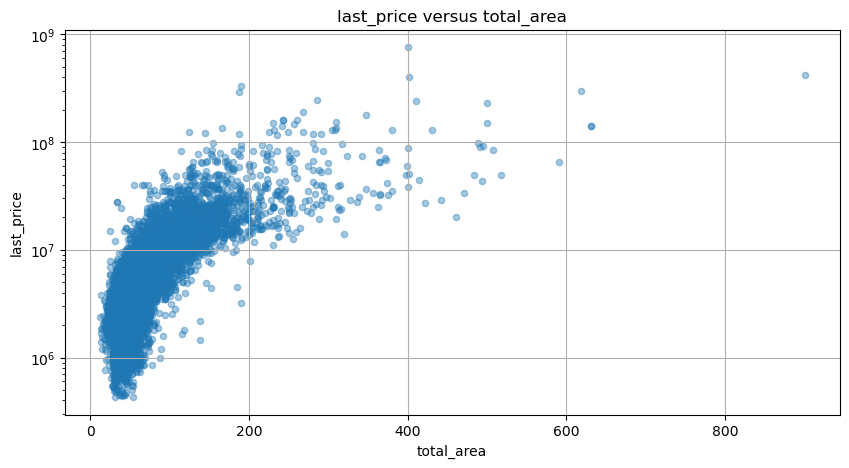

Корреляция между total_area и last_price составляет: 0.6537


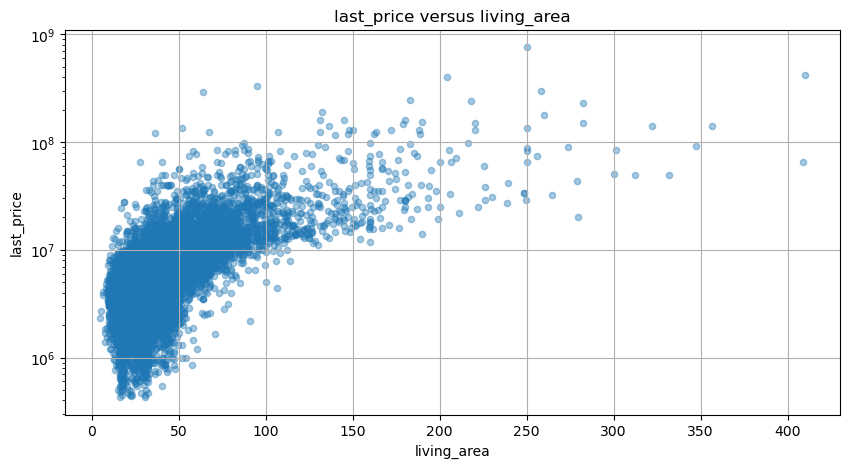

Корреляция между living_area и last_price составляет: 0.586


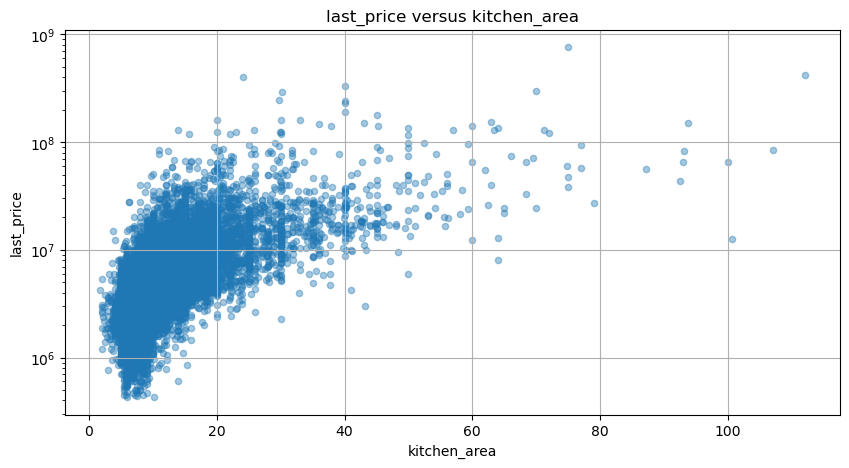

Корреляция между kitchen_area и last_price составляет: 0.5208


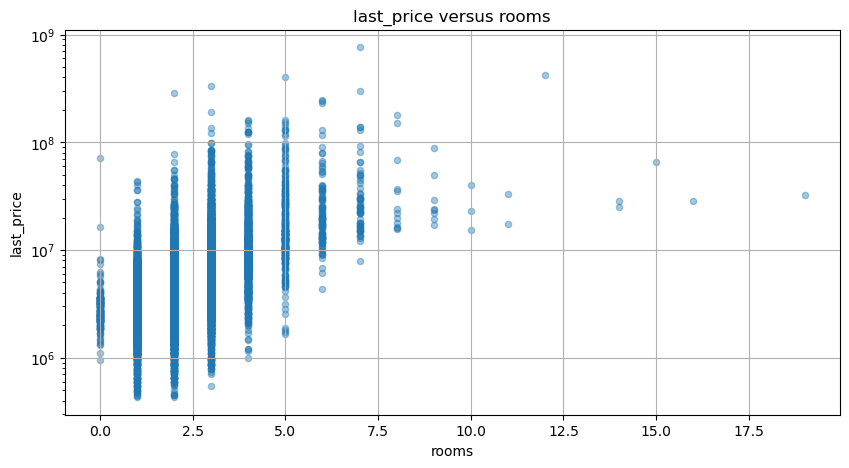

Корреляция между rooms и last_price составляет: 0.3633


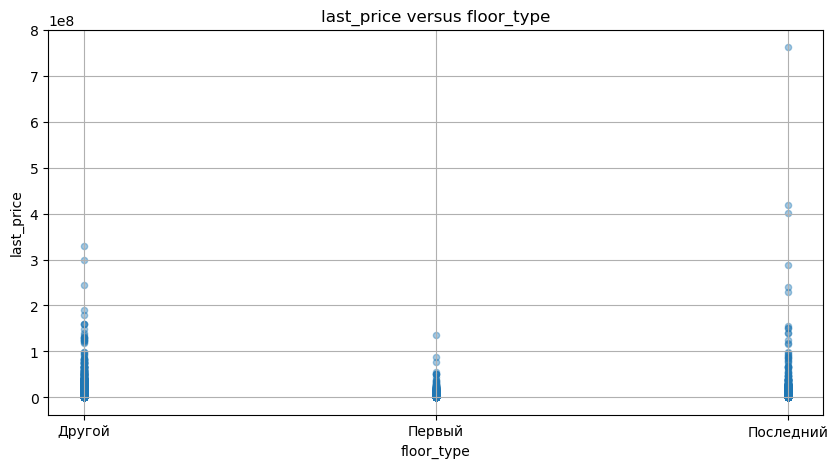

Для параметра floor_type не определить величину корреляции.


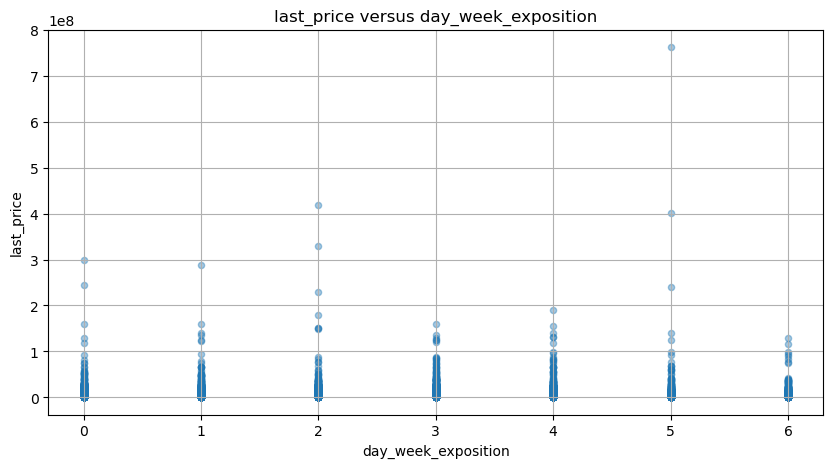

Корреляция между day_week_exposition и last_price составляет: 0.0015


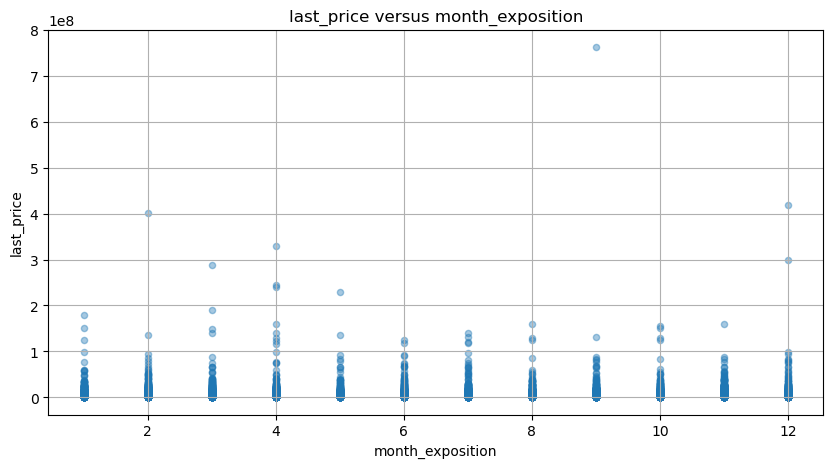

Корреляция между month_exposition и last_price составляет: 0.0027


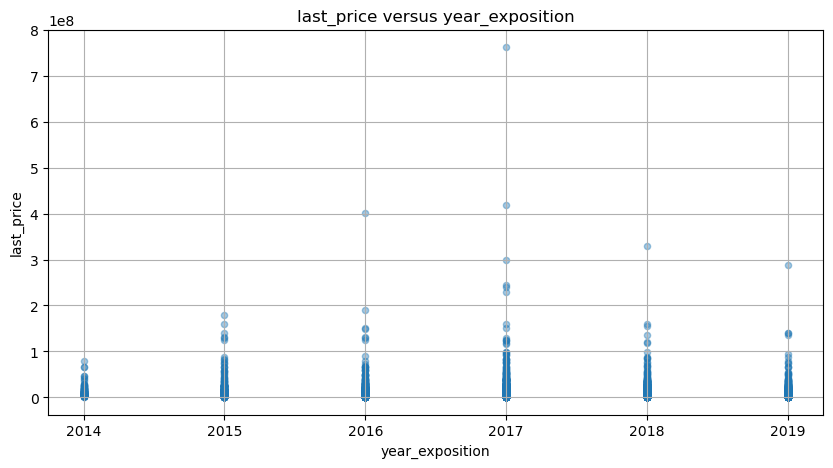

Корреляция между year_exposition и last_price составляет: -0.043


In [169]:
for col in parametr_list_dep:
    plot_corr(data, col, 'last_price')

**Выводы**

Исходя из полученных данных можно сказать следующее:
- факторами, которые меньше всего влияют на стоимость квартиры, являются день, месяц и год размещения объявления.
- на стоимость некоторое влияние оказывает номер этажа квартиры. Так, на первых этажах расположены квартиры с меньшей стоимостью, чем на остальных.
- число комнат влияет на стоимость - с ростом количества комнат растет и стоимость квартиры. Однако, имеются некоторые странные выбросы для большого числа комнат (7 и более), у которых стоимость квартиры снижается вопреки ожиданиям. Скорее всего, для таких квартир были указанны некорректные данные о стоимости и/или о числе комнат. Также стоит учесть тот факт, что для некоторых квартир число комнат не было указано вовсе. Эти данные могут искажать результат.
- больше всего влияния на стоимость оказывает общая площадь квартиры. Корреляция составляет 65 %. Чуть меньше влияют на стоимость площадь жилой зоны и площадь кухни - корреляции для этих параметров составили 58 и 52 % соответственно.

#### Исследование средней цены одного м$^2$ жилья для десяти наиболее часто встречающихся населенных пунктов


Сначала определим количество объявлений в каждом НП и выведем на экран результат первых 10 НП, отсортированных по убыванию числа объявлений в этих НП:

In [170]:
cities_summary = data.pivot_table(values='last_price', index='locality_name', aggfunc='count')
cities_summary = cities_summary['last_price'].sort_values(ascending=False).head(10)
cities_summary

locality_name
Санкт-Петербург      15721
посёлок Мурино         556
посёлок Шушары         440
Всеволожск             398
Пушкин                 369
Колпино                338
посёлок Парголово      327
Гатчина                307
деревня Кудрово        299
Выборг                 237
Name: last_price, dtype: int64

Чтобы определить среднюю цену одного квардратного метра, необходимо для каждой квартиры определить среднюю цену одного квадратного метра, а затем найти среднее от этих средних для всех квартир в каждом городе. Для этого в исходной таблице был создан новый столбец `price_per_metr`, в котором посчитана цена 1 м$^2$.

Выполним группировку по городам и посчитаем среднее средней цены за 1 м$^2$ квартир:

In [171]:
cities_summary_price = data.pivot_table(values='price_per_metr', index='locality_name', aggfunc='mean')
cities_summary_price['price_per_metr'] = cities_summary_price['price_per_metr'].astype('int')
cities_summary_price.loc[cities_summary.index].sort_values(by='price_per_metr', ascending=False)

,price_per_metr
locality_name,
Санкт-Петербург,114857
Пушкин,103125
деревня Кудрово,92473
посёлок Парголово,90175
посёлок Мурино,85681
посёлок Шушары,78677
Колпино,75424
Гатчина,68746
Всеволожск,68654


**Вывод**

Как и следовало ожидать, самая высокая средняя цена одного квадратного метра жилья принадлежит квартирам из Санкт-Петербурга: 114857 руб/м$^2$. На десятом, последнем месте данной выборки, расположены квартиры из города Выборг со средней ценой одного квадратного метра: 58141 руб/м$^2$

#### Исследование стоимости квартир в Санкт-Петербурге

Сохраним в новой переменной строки, относящиеся к Санкт-Петербургу:

In [172]:
data_spb = data[data['locality_name'] == 'Санкт-Петербург']

In [173]:
data_spb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15721 entries, 0 to 23697
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          15721 non-null  int64         
 1   last_price            15721 non-null  float64       
 2   total_area            15721 non-null  float64       
 3   first_day_exposition  15721 non-null  datetime64[ns]
 4   rooms                 15721 non-null  int64         
 5   ceiling_height        15721 non-null  float64       
 6   floors_total          15721 non-null  Int32         
 7   living_area           15721 non-null  float64       
 8   floor                 15721 non-null  int64         
 9   is_apartment          15721 non-null  bool          
 10  studio                15721 non-null  bool          
 11  open_plan             15721 non-null  bool          
 12  kitchen_area          15721 non-null  float64       
 13  balcony              

In [174]:
print(f'Макимальное удаление квартир от центра города: {data_spb.city_center_km.max()}')

Макимальное удаление квартир от центра города: 29.0


Необходимо посчитать среднюю стоимость квартир в зависимости от расстояния до центра. Для этого сгруппируем данные по столбцу `city_center_km` и определим среднюю стоимость для каждого километра. Также добавим в сводную таблицу информацию о количестве продаваемых квартир на каждом километре.

In [175]:
spb_price_dist = data_spb.pivot_table(index='city_center_km', values='last_price', aggfunc=['mean', 'count'])
spb_price_dist

,mean,count
,last_price,last_price
city_center_km,,
0.0,3.144912e+07,27
1.0,2.120672e+07,192
2.0,1.778832e+07,310
3.0,1.112658e+07,350
4.0,1.330428e+07,688
5.0,1.449912e+07,920
6.0,1.533842e+07,618
7.0,1.477515e+07,420


Построим график:

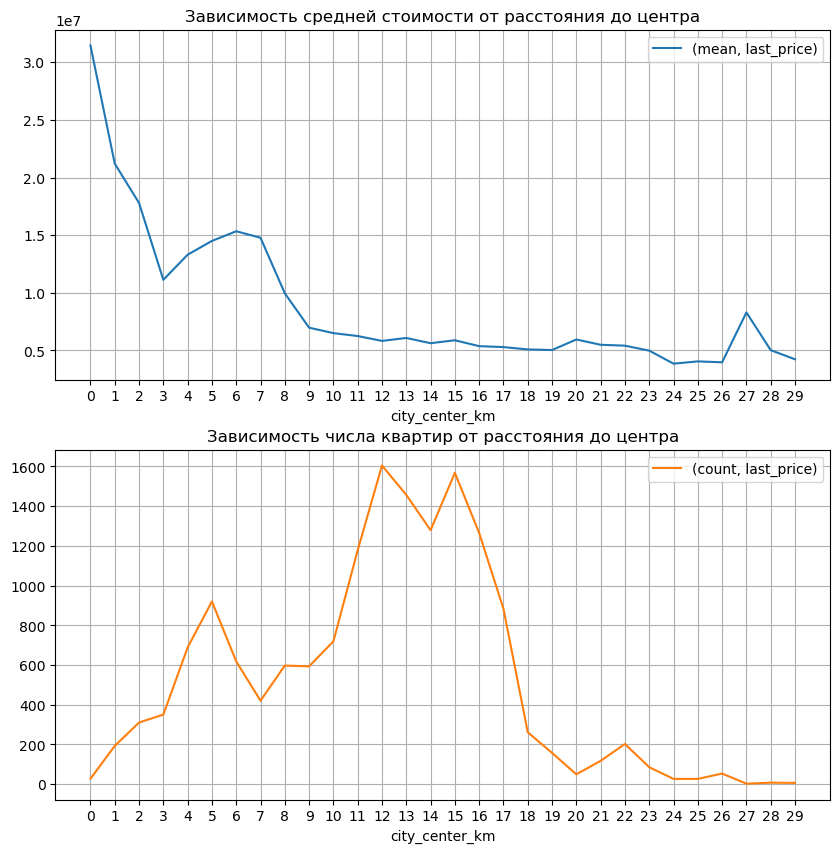

In [176]:
spb_price_dist.plot(y=[('mean', 'last_price'), ('count', 'last_price')],
                    subplots=True, sharex=False, title=['Зависимость средней стоимости от расстояния до центра',
                    'Зависимость числа квартир от расстояния до центра'], grid=True, xticks=range(0, 30), figsize=(10, 10))
plt.show()

**Вывод**

Исходя из полученного графика можно сделать вывод, что наиболее дорогие квартиры расположены в центре Санкт-Петербурга. С ростом расстояния до центра города стоимость квартир падает, но на диапазоне от 3 до 7 км наблюдается увеличение средней стоимости квартир. Возможно это вызвано тем, что увеличивается общее число продаваемых квартир на этой дистанции и, как следствие, возрастает число дорогих квартир, а за ними и среднее. После 7 км наблюдается спад средней стоимости до дистанции в 12 км. При этом число квартир растет. Данная закономерность объясняется тем, что на такой дистнации продаются квартиры в спальных районах, а их стоимость, как известно, ниже, чем стоимость квартир в центре.

Далее стоимость практически не изменяется. В конце зависимости наблюдается пик на 27 км. Исходя из таблицы на такой дистанции продаются всего лишь две квартиры. Судить о средней стоимости по таким скудным данным нельзя. Поэтому конец графика считаем непоказательным, так как данных недостаточно.

### Напишите общий вывод

Проведен анализ исходных данных на наличие пропусков и аномальных значений. Там, где это было возможно, пропуски и аномалии были заполнены некими средними значениями. В остальных случаях пропуски были оставлены. Удаление строк не производилось.

В исходную таблицу были добавлены новые столбцы, согласно заданию.

В ходе исследования датафрейма были построены гистограммы распределения для ряда параметров. Для каждой гистограммы были описанны выявленные особенности.

Была изучена скорость продажи квартир. Определено, что половина из всех представленных квартир была продана менее, чем за 95 дней. В качестве быстрых продаж приняты те, которые были совершены за первые 45 дней. В качестве необычно долгих обозначены те квартиры, длительность продажи которых превышает 512 дней.

Изучены взаимосвязи между стоимостью квартиры и различными факторами. Определено, что сильнее всего на стоимость влияет площадь квартиры - с ростом площади увеличивается и стоимость. Также определено, что на стоимость квартиры практически не влияет дата выставления объявления.

Определена средняя цена одного квадратного метра для десяти населенных пунктов с наибольшем числом предложений о продаже квартир. Установлено, что наибольшая среднерыночная цена квадратного метра принадлежит квартирам из Санкт-Петербурга - 114857 руб/м$^2$. На десятом, последнем месте данной выборки, расположены квартиры из города Выборг со средней ценой одного квадратного метра 58141 руб/м$^2$

Для квартир, расположенных в Санкт-Петербурге, построена зависимость стоимости квартиры от расстояния до центра города. Исходя из полученных данных, прослеживается зависимость уменьшения стоимости квартиры по мере удаления от центра. При этом, для квартир, расположенных на дистанции 3 - 7 км наблюдается увеличение средней стоимости квартир.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Файл с данными открыт.
- [x]  Файл с данными изучен: выведены первые строки, использован метод `info()`, построены гистограммы.
- [x]  Найдены пропущенные значения.
- [x]  Пропущенные значения заполнены там, где это возможно.
- [x]  Объяснено, какие пропущенные значения обнаружены.
- [x]  В каждом столбце установлен корректный тип данных.
- [x]  Объяснено, в каких столбцах изменён тип данных и почему.
- [x]  Устранены неявные дубликаты в названиях населённых пунктов.
- [x]  Обработаны редкие и выбивающиеся значения (аномалии).
- [x]  В таблицу добавлены новые параметры:
       – цена одного квадратного метра;
       – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
       – месяц публикации объявления;
       – год публикации объявления;
       – тип этажа квартиры (значения — «первый», «последний», «другой»);
       – расстояние до центра города в километрах.
- [x]  Изучены и описаны параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего парка.
- [x]  Выполнено задание «Изучите, как быстро продавались квартиры (столбец `days_exposition`)»:
    - построена гистограмма;
    - рассчитаны среднее и медиана;
    - описано, сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими.
- [x]  Выполнено задание «Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта». Построены графики, которые показывают зависимость цены от параметров:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - количество комнат;
        - тип этажа, на котором расположена квартира (первый, последний, другой);
        - дата размещения (день недели, месяц, год).
- [x]  Выполнено задание «Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений»:
    - выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра.
- [x]  Выполнено задание «Выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите их среднюю стоимость на разном удалении от центра»:
    -  учтён каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
    -  описано, как стоимость объекта зависит от расстояния до центра города;
    -  построен график изменения средней цены для каждого километра от центра Петербурга.
- [x]  На каждом этапе сделаны промежуточные выводы.
- [x]  В конце проекта сделан общий вывод.